### Imports

In [30]:
import requests
import json
import pandas as pd
import ast
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim import corpora
from collections import Counter
import pandas as pd

import re
from collections import Counter
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Label TaxoEntities
Now that entities have been extracted with TaxoNERD, we label them

In [80]:
# Function to flatten a list of lists (after converting from string representation) --> Functioin thought for handling the TaxRef multi-entity returns
def flatten_list_of_lists(row):
    # Convert the string representation to actual list
    lists = ast.literal_eval(row) #string_to_list(row)
    # Flatten the list of lists
    flattened = [(taxref, name) for sublist in lists for (taxref, name, _) in sublist]
    return flattened


def count_unique_entities_per_row_and_sort(entities_column):
    """
    Receives a pandas Series where each row contains a list or a string representation of a list of entities.
    Returns a pandas Series where each row contains an OrderedDict with the count of unique entities or tuples,
    sorted by their counts in descending order. It handles case insensitivity for strings and maintains the integrity of tuples.
    """
    def count_entities(row_entities):
        try:
            if isinstance(row_entities, str):
                # Safely convert string representation to actual list
                row_entities = ast.literal_eval(row_entities)

            row_entities_list = []
            for entity in row_entities:
                if isinstance(entity, tuple):
                    # Handle tuples by keeping them intact
                    row_entities_list.append(entity)
                elif isinstance(entity, str):
                    # Convert strings to lowercase for case insensitivity
                    row_entities_list.append(entity.lower())
                else:
                    # Ignore non-string, non-tuple entities
                    continue

            # Count entities/tuples and sort them
            entity_counter = Counter(row_entities_list)
            sorted_entities = dict(sorted(entity_counter.items(), key=lambda x: x[1], reverse=True))

            return sorted_entities
        except Exception as e:
            print(f"Error processing row: {e}")
            return {}

    # Apply the count_entities function to each row in the entities_column
    return entities_column.apply(count_entities)

## Sample of 20 papers (Dataset_2)

In [19]:
file_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_comparison.csv'
papers_df = pd.read_csv(file_path)
papers_df

,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD_x,TaxoEntitiesMD_y,TaxoRefEntitiesBB2_x,TaxoRefEntitiesBB2_y,fileMain_s
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[[('GBIF:3183002', 'clove', 0.7634411454200745...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[[('TAXREF:630768', 'Syzygium aromaticum', 1.0...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[[('TAXREF:447477', 'Coffee tree', 0.891860187...",NaN,https://hal.inrae.fr/hal-03461601/document
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[[('GBIF:9065640', 'Tyto novaehollandiae novae...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[[('TAXREF:712345', 'Proto novaehollandiae', 0...","['Larchive ouverte pluridisciplinaire HAL', 'C...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[[('TAXREF:712345', 'Proto novaehollandiae', 0...",NaN,https://hal.science/hal-03829927/document
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[[('TAXREF:592318', 'Coralliophila norfolk', 0...",NaN,https://hal.science/hal-02350603/document
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[[('GBIF:5786457', 'Sateré Marmoset', 0.771187...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[[('TAXREF:841466', 'Paullinia cupana var. sor...","['Mlanie', 'Larchive ouverte pluridisciplinair...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[[('TAXREF:734243', 'Guarea guara', 0.78600811...",NaN,https://shs.hal.science/halshs-02937670/document
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[[('GBIF:4494312', 'Spilomena beata Blüthgen',...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[[('TAXREF:210056', 'Cephalochilus Blüthgen, 1...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],NaN,https://cnam.hal.science/hal-04080723/document
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[[('GBIF:7207559', 'Agrias pericles pericles',...","['Katia Frangoudes, et', 'PERICLES project,1',...","[[('TAXREF:750521', 'Agrias pericles', 0.73106...","['Katia Frangoudes, et al.', 'Larchive ouverte...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[[('TAXREF:730671', 'Salmonia', 0.851587712764...",NaN,https://hal.inrae.fr/hal-04085146/document
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[[('GBIF:4755059', 'Aedenus', 0.77683901786804...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[[('TAXREF:188832', 'Aedes', 0.773127555847168...","['Larchive ouverte pluridisciplinaire HAL', 'A...","['Larchive ouverte pluridisciplinaire HAL', 'A...","[[('TAXREF:188832', 'Aedes', 1.0), ('TAXREF:82...",NaN,https://hal.sc

In [20]:
file_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities-20-MD_NCBI_v3.csv'
nbci_entities = pd.read_csv(file_path)
nbci_entities

,fileMain_s,TaxoEntitiesMD2_NCBI
0,https://hal.inrae.fr/hal-03461601/document,"[[('NCBI:219868', 'clove', 0.7502766251564026)..."
1,https://hal.science/hal-03829927/document,"[[('NCBI:507994', 'Tyto novaehollandiae', 0.91..."
2,https://hal.science/hal-02350603/document,[]
3,https://shs.hal.science/halshs-02937670/document,"[[('NCBI:392746', 'Paullinia cupana var. sorbi..."
4,https://cnam.hal.science/hal-04080723/document,"[[('NCBI:378092', 'Molnaria', 0.71836060285568..."
5,https://hal.inrae.fr/hal-04085146/document,"[[('NCBI:172714', 'kelp bass', 0.8092926144599..."
6,https://hal.science/hal-03953883/document,"[[('NCBI:1250594', 'Osmia universitatis', 0.70..."
7,https://hal.science/hal-03482462/document,"[[('NCBI:1101089', 'Cedestis', 0.7583553791046..."
8,https://hal.inrae.fr/hal-04285321/document,"[[('NCBI:9170', 'starlings', 1.0)], [('NCBI:91..."
9,https://hal.science/hal-03511302/document,"[[('NCBI:301659', 'Carmenta', 0.88153719902038..."


In [21]:
papers_df = papers_df.merge(nbci_entities, on='fileMain_s', how='left')
papers_df

,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD_x,TaxoEntitiesMD_y,TaxoRefEntitiesBB2_x,TaxoRefEntitiesBB2_y,fileMain_s,TaxoEntitiesMD2_NCBI
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[[('GBIF:3183002', 'clove', 0.7634411454200745...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[[('TAXREF:630768', 'Syzygium aromaticum', 1.0...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[[('TAXREF:447477', 'Coffee tree', 0.891860187...",NaN,https://hal.inrae.fr/hal-03461601/document,"[[('NCBI:219868', 'clove', 0.7502766251564026)..."
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[[('GBIF:9065640', 'Tyto novaehollandiae novae...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[[('TAXREF:712345', 'Proto novaehollandiae', 0...","['Larchive ouverte pluridisciplinaire HAL', 'C...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[[('TAXREF:712345', 'Proto novaehollandiae', 0...",NaN,https://hal.science/hal-03829927/document,"[[('NCBI:507994', 'Tyto novaehollandiae', 0.91..."
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[[('TAXREF:592318', 'Coralliophila norfolk', 0...",NaN,https://hal.science/hal-02350603/document,[]
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[[('GBIF:5786457', 'Sateré Marmoset', 0.771187...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[[('TAXREF:841466', 'Paullinia cupana var. sor...","['Mlanie', 'Larchive ouverte pluridisciplinair...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[[('TAXREF:734243', 'Guarea guara', 0.78600811...",NaN,https://shs.hal.science/halshs-02937670/document,"[[('NCBI:392746', 'Paullinia cupana var. sorbi..."
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[[('GBIF:4494312', 'Spilomena beata Blüthgen',...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[[('TAXREF:210056', 'Cephalochilus Blüthgen, 1...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],NaN,https://cnam.hal.science/hal-04080723/document,"[[('NCBI:378092', 'Molnaria', 0.71836060285568..."
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[[('GBIF:7207559', 'Agrias pericles pericles',...","['Katia Frangoudes, et', 'PERICLES project,1',...","[[('TAXREF:750521', 'Agrias pericles', 0.73106...","['Katia Frangoudes, et al.', 'Larchive ouverte...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[[('TAXREF:730671', 'Salmonia', 0.851587712764...",NaN,https://hal.inrae.fr/hal-04085146/document,"[[('NCBI:172714', 'kelp bass', 0.8092926144599..."
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[[('GBIF:4755059', 'Aedenus', 0.7768390178680

Remove repeated columns

In [27]:
papers_df.columns.to_list()

['BABEL_entities',
 'TaxoEntitiesBB',
 'TaxoEntitiesBB2',
 'TaxoEntitiesMD2',
 'TaxoEntitiesMD2_GBIF',
 'TaxoEntitiesMD2_x',
 'TaxoEntitiesMD2_y',
 'TaxoEntitiesMD_x',
 'TaxoEntitiesMD_y',
 'TaxoRefEntitiesBB2_x',
 'TaxoRefEntitiesBB2_y',
 'fileMain_s',
 'TaxoEntitiesMD2_NCBI']

In [29]:
def validate_and_clean_columns(df):
    columns = df.columns
    to_drop = []
    differences = {}

    for col in columns:
        if col.endswith('_x'):
            base_col = col[:-2]
            col_y = base_col + '_y'
            if col_y in columns:
                if df[col].equals(df[col_y]):
                    df.rename(columns={col: base_col}, inplace=True)
                    to_drop.append(col_y)
                else:
                    differences[base_col] = df[df[col] != df[col_y]]
    
    df.drop(columns=to_drop, inplace=True)
    return df, differences

# Example usage
papers_df, differences = validate_and_clean_columns(papers_df)

# If you want to display the rows where there are differences
for base_col, diff_df in differences.items():
    print(f"Differences in {base_col}:")
    print(diff_df)

Differences in TaxoEntitiesMD2:
                                       BABEL_entities  \
0   ['France (LOC)', 'Creative Commons Attribution...   
1   ['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...   
2   ['People and Nature (MISC)', 'Biraben (PER)', ...   
3   ['France (LOC)', 'Mélanie Congretel (PER)', 'F...   
4   ['People and Nature (MISC)', 'Werner Ulrich (P...   
5   ['France (LOC)', 'Creative Commons Attribution...   
6   ['France (LOC)', 'Bengaluru (LOC)', 'India (LO...   
7   ['People and Nature (MISC)', 'Emilia Pramova (...   
8   ['People and Nature (MISC)', 'Thomas Evans (PE...   
9   ['France (LOC)', 'Creative Commons Attribution...   
10  ['France (LOC)', 'Creative Commons Attribution...   
11  ['People and Nature (MISC)', 'Madagascar (LOC)...   
12  ['People and Nature (MISC)', 'Transfrontier Co...   
13  ['France (LOC)', 'Lauric Thiault (PER)', 'Stef...   
14  ['People and Nature (MISC)', 'Mathilde Jackson...   
15  ['France (LOC)', 'Laos (LOC)', 'Gilles Maurer ...   

                                       BABEL_entities  \
0   ['France (LOC)', 'Creative Commons Attribution...   
1   ['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...   
2   ['People and Nature (MISC)', 'Biraben (PER)', ...   
3   ['France (LOC)', 'Mélanie Congretel (PER)', 'F...   
4   ['People and Nature (MISC)', 'Werner Ulrich (P...   
5   ['France (LOC)', 'Creative Commons Attribution...   
6   ['France (LOC)', 'Bengaluru (LOC)', 'India (LO...   
7   ['People and Nature (MISC)', 'Emilia Pramova (...   
8   ['People and Nature (MISC)', 'Thomas Evans (PE...   
9   ['France (LOC)', 'Creative Commons Attribution...   
10  ['France (LOC)', 'Creative Commons Attribution...   
11  ['People and Nature (MISC)', 'Madagascar (LOC)...   
12  ['People and Nature (MISC)', 'Transfrontier Co...   
13  ['France (LOC)', 'Lauric Thiault (PER)', 'Stef...   
14  ['People and Nature (MISC)', 'Mathilde Jackson...   
15  ['France (LOC)', 'Laos (LOC)', 'Gilles Maurer ...   
16  ['France (LOC)', 'Christoph

In [30]:
papers_df

,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD,TaxoRefEntitiesBB2_x,TaxoRefEntitiesBB2_y,fileMain_s,TaxoEntitiesMD2_NCBI
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[(TAXREF:447477, Coffee tree), (TAXREF:630768,...",NaN,https://hal.inrae.fr/hal-03461601/document,"[(NCBI:219868, clove), (NCBI:219868, clove), (..."
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...",NaN,https://hal.science/hal-03829927/document,"[(NCBI:507994, Tyto novaehollandiae), (NCBI:21..."
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[(TAXREF:592318, Coralliophila norfolk)]",NaN,https://hal.science/hal-02350603/document,[]
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(TAXREF:841466, Paullinia cupana var. sorbili...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[(TAXREF:734243, Guarea guara), (TAXREF:734243...",NaN,https://shs.hal.science/halshs-02937670/document,"[(NCBI:392746, Paullinia cupana var. sorbilis)..."
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(GBIF:4494312, Spilomena beata Blüthgen), (GB...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(TAXREF:210056, Cephalochilus Blüthgen, 1939)...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],NaN,https://cnam.hal.science/hal-04080723/document,"[(NCBI:378092, Molnaria), (NCBI:122956, Setia)..."
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(GBIF:7207559, Agrias pericles pericles), (GB...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(TAXREF:750521, Agrias pericles), (TAXREF:733...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[(TAXREF:730671, Salmonia), (TAXREF:186049, ga...",NaN,https://hal.inrae.fr/hal-04085146/document,"[(NCBI:172714, kelp bass), (NCBI:172714, kelp ..."
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(GBIF:4755059, Aedenus), (GBIF:2199187, Arctu...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...","['Larchive ouverte pluridisciplinaire HAL', 'A...","[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...",NaN,https://hal.science/hal-03953883/document,"[(NCBI:1250594, Osmia universitatis), (NCBI:14..."
7,"['People and Nature (MISC

In [33]:
differences

{'TaxoEntitiesMD2':                                        BABEL_entities  \
 0   ['France (LOC)', 'Creative Commons Attribution...   
 1   ['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...   
 2   ['People and Nature (MISC)', 'Biraben (PER)', ...   
 3   ['France (LOC)', 'Mélanie Congretel (PER)', 'F...   
 4   ['People and Nature (MISC)', 'Werner Ulrich (P...   
 5   ['France (LOC)', 'Creative Commons Attribution...   
 6   ['France (LOC)', 'Bengaluru (LOC)', 'India (LO...   
 7   ['People and Nature (MISC)', 'Emilia Pramova (...   
 8   ['People and Nature (MISC)', 'Thomas Evans (PE...   
 9   ['France (LOC)', 'Creative Commons Attribution...   
 10  ['France (LOC)', 'Creative Commons Attribution...   
 11  ['People and Nature (MISC)', 'Madagascar (LOC)...   
 12  ['People and Nature (MISC)', 'Transfrontier Co...   
 13  ['France (LOC)', 'Lauric Thiault (PER)', 'Stef...   
 14  ['People and Nature (MISC)', 'Mathilde Jackson...   
 15  ['France (LOC)', 'Laos (LOC)', 'Gilles Maurer ..

Continue with the count

In [23]:
# Apply the function to each row in the 'TaxoRefEntitiesBB2' column
papers_df['TaxoEntitiesMD2_GBIF'] = papers_df['TaxoEntitiesMD2_GBIF'].apply(flatten_list_of_lists)
papers_df['TaxoEntitiesMD2_y'] = papers_df['TaxoEntitiesMD2_y'].apply(flatten_list_of_lists)
papers_df['TaxoRefEntitiesBB2_x'] = papers_df['TaxoRefEntitiesBB2_x'].apply(flatten_list_of_lists)
papers_df['TaxoEntitiesMD2_NCBI'] = papers_df['TaxoEntitiesMD2_NCBI'].apply(flatten_list_of_lists)
papers_df

,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD_x,TaxoEntitiesMD_y,TaxoRefEntitiesBB2_x,TaxoRefEntitiesBB2_y,fileMain_s,TaxoEntitiesMD2_NCBI
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[(TAXREF:447477, Coffee tree), (TAXREF:630768,...",NaN,https://hal.inrae.fr/hal-03461601/document,"[(NCBI:219868, clove), (NCBI:219868, clove), (..."
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...","['Larchive ouverte pluridisciplinaire HAL', 'C...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...",NaN,https://hal.science/hal-03829927/document,"[(NCBI:507994, Tyto novaehollandiae), (NCBI:21..."
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[(TAXREF:592318, Coralliophila norfolk)]",NaN,https://hal.science/hal-02350603/document,[]
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(TAXREF:841466, Paullinia cupana var. sorbili...","['Mlanie', 'Larchive ouverte pluridisciplinair...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[(TAXREF:734243, Guarea guara), (TAXREF:734243...",NaN,https://shs.hal.science/halshs-02937670/document,"[(NCBI:392746, Paullinia cupana var. sorbilis)..."
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(GBIF:4494312, Spilomena beata Blüthgen), (GB...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(TAXREF:210056, Cephalochilus Blüthgen, 1939)...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],NaN,https://cnam.hal.science/hal-04080723/document,"[(NCBI:378092, Molnaria), (NCBI:122956, Setia)..."
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(GBIF:7207559, Agrias pericles pericles), (GB...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(TAXREF:750521, Agrias pericles), (TAXREF:733...","['Katia Frangoudes, et al.', 'Larchive ouverte...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[(TAXREF:730671, Salmonia), (TAXREF:186049, ga...",NaN,https://hal.inrae.fr/hal-04085146/document,"[(NCBI:172714, kelp bass), (NCBI:172714, kelp ..."
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(GBIF:4755059, Aedenus), (GBIF:2199187, Arctu...","['

In [40]:
papers_df.rename(columns={'TaxoRefEntitiesBB2_x': 'TaxRef_BB2'}, inplace=True)
papers_df.rename(columns={'TaxoEntitiesMD2_y': 'TaxRef_MD2'}, inplace=True)
papers_df.rename(columns={'TaxoEntitiesMD2_GBIF': 'GBIF_MD2'}, inplace=True)
papers_df.rename(columns={'TaxoEntitiesMD2_NCBI': 'NCBI_MD2'}, inplace=True)
papers_df.rename(columns={'TaxoEntitiesMD2_x': 'TaxoEntitiesMD2'}, inplace=True)
papers_df.dropna(axis=1, how='all', inplace=True)
print(papers_df.columns.to_list())
papers_df

['BABEL_entities', 'TaxoEntitiesBB', 'TaxoEntitiesBB2', 'TaxoEntitiesMD2', 'GBIF_MD2', 'TaxoEntitiesMD2', 'TaxRef_MD2', 'TaxoEntitiesMD', 'TaxRef_BB2', 'fileMain_s', 'NCBI_MD2']


,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,GBIF_MD2,TaxoEntitiesMD2,TaxRef_MD2,TaxoEntitiesMD,TaxRef_BB2,fileMain_s,NCBI_MD2
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[(TAXREF:447477, Coffee tree), (TAXREF:630768,...",https://hal.inrae.fr/hal-03461601/document,"[(NCBI:219868, clove), (NCBI:219868, clove), (..."
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...",https://hal.science/hal-03829927/document,"[(NCBI:507994, Tyto novaehollandiae), (NCBI:21..."
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[(TAXREF:592318, Coralliophila norfolk)]",https://hal.science/hal-02350603/document,[]
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(TAXREF:841466, Paullinia cupana var. sorbili...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[(TAXREF:734243, Guarea guara), (TAXREF:734243...",https://shs.hal.science/halshs-02937670/document,"[(NCBI:392746, Paullinia cupana var. sorbilis)..."
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(GBIF:4494312, Spilomena beata Blüthgen), (GB...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(TAXREF:210056, Cephalochilus Blüthgen, 1939)...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],https://cnam.hal.science/hal-04080723/document,"[(NCBI:378092, Molnaria), (NCBI:122956, Setia)..."
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(GBIF:7207559, Agrias pericles pericles), (GB...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(TAXREF:750521, Agrias pericles), (TAXREF:733...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[(TAXREF:730671, Salmonia), (TAXREF:186049, ga...",https://hal.inrae.fr/hal-04085146/document,"[(NCBI:172714, kelp bass), (NCBI:172714, kelp ..."
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(GBIF:4755059, Aedenus), (GBIF:2199187, Arctu...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...","['Larchive ouverte pluridisciplinaire HAL', 'A...","[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...",https://hal.science/hal-03953883/document,"[(NCBI:1250594, Osmia universitatis), (NCBI:14..."
7,"['People and Nature (MISC)', 'Emilia Pramova (...","['Ysica Quispe Conde3,6', 'Houria Djoudi7', 'B...","['Yésica Quis

In [43]:
papers_df.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_TaxoNERD-Counts_v6.csv', index=False, encoding='utf-8')


In [46]:
desired_columns = [
    'fileMain_s', 'TaxRef_MD2', 'GBIF_MD2', 'NCBI_MD2'
]

# Reorder the columns
entities_md2 = papers_df[desired_columns]
entities_md2

,fileMain_s,TaxRef_MD2,GBIF_MD2,NCBI_MD2
0,https://hal.inrae.fr/hal-03461601/document,"[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","[(NCBI:219868, clove), (NCBI:219868, clove), (..."
1,https://hal.science/hal-03829927/document,"[(TAXREF:712345, Proto novaehollandiae), (TAXR...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","[(NCBI:507994, Tyto novaehollandiae), (NCBI:21..."
2,https://hal.science/hal-02350603/document,[],[],[]
3,https://shs.hal.science/halshs-02937670/document,"[(TAXREF:841466, Paullinia cupana var. sorbili...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","[(NCBI:392746, Paullinia cupana var. sorbilis)..."
4,https://cnam.hal.science/hal-04080723/document,"[(TAXREF:210056, Cephalochilus Blüthgen, 1939)...","[(GBIF:4494312, Spilomena beata Blüthgen), (GB...","[(NCBI:378092, Molnaria), (NCBI:122956, Setia)..."
5,https://hal.inrae.fr/hal-04085146/document,"[(TAXREF:750521, Agrias pericles), (TAXREF:733...","[(GBIF:7207559, Agrias pericles pericles), (GB...","[(NCBI:172714, kelp bass), (NCBI:172714, kelp ..."
6,https://hal.science/hal-03953883/document,"[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...","[(GBIF:4755059, Aedenus), (GBIF:2199187, Arctu...","[(NCBI:1250594, Osmia universitatis), (NCBI:14..."
7,https://hal.science/hal-03482462/document,"[(TAXREF:211675, Cedestis), (TAXREF:67732, Mau...","[(GBIF:4270410, palm), (GBIF:4526488, Acedes),...","[(NCBI:1101089, Cedestis), (NCBI:47387, Schoen..."
8,https://hal.inrae.fr/hal-04285321/document,"[(TAXREF:4516, Sturnus vulgaris), (TAXREF:1886...","[(GBIF:2489099, Starlings), (GBIF:9350, Starli...","[(NCBI:9170, starlings), (NCBI:9172, Sturnus v..."
9,https://hal.science/hal-03511302/document,"[(TAXREF:746693, Carmenta), (TAXREF:746693, Ca...","[(GBIF:7566147, Carmenta), (GBIF:7772277, Carm...","[(NCBI:301659, Carmenta), (NCBI:272805, Bias),..."


In [49]:
!pip install matplotlib-venn

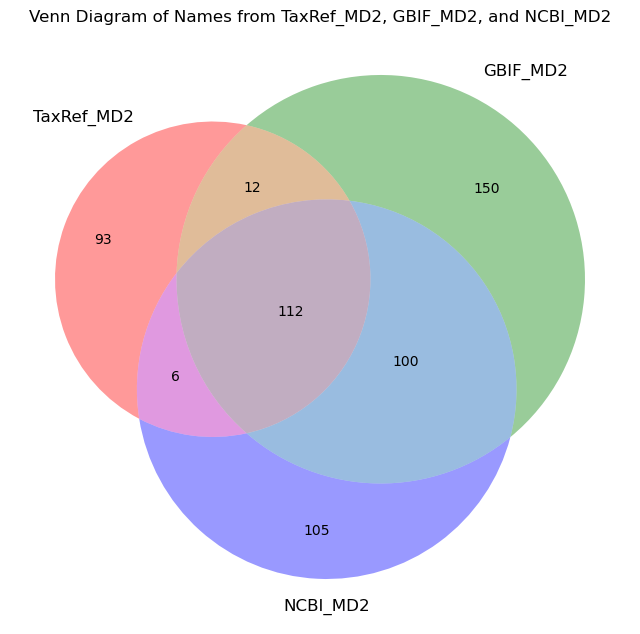

In [50]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import re

# Function to extract names from tuples
def extract_names(column):
    names = set()
    for row in column:
        for item in row:
            names.add(item[1])
    return names

# Extract names from each column
taxref_names = extract_names(entities_md2['TaxRef_MD2'])
gbif_names = extract_names(entities_md2['GBIF_MD2'])
ncbi_names = extract_names(entities_md2['NCBI_MD2'])

# Plot the Venn Diagram
plt.figure(figsize=(8, 8))
venn3([taxref_names, gbif_names, ncbi_names], ('TaxRef_MD2', 'GBIF_MD2', 'NCBI_MD2'))
plt.title("Venn Diagram of Names from TaxRef_MD2, GBIF_MD2, and NCBI_MD2")
plt.show()

In [56]:
max_length = max(len(unique_taxref), len(unique_gbif), len(unique_ncbi))

# Pad lists with None to make them of equal length
unique_taxref_list = list(unique_taxref)# + [None] * (max_length - len(unique_taxref))
unique_gbif_list = list(unique_gbif) #+ [None] * (max_length - len(unique_gbif))
unique_ncbi_list = list(unique_ncbi) #+ [None] * (max_length - len(unique_ncbi))

# Create a DataFrame with the unique names for each set
unique_names = {
    'TaxRef_MD2': unique_taxref_list,
    'GBIF_MD2': unique_gbif_list,
    'NCBI_MD2': unique_ncbi_list
}
# Display the DataFrame
unique_names

{'TaxRef_MD2': ['Guineafowl moray',
  'Pink Sea Fan',
  'Chafer',
  'Common Starling',
  'Pyralis palpalis',
  'Bird flies',
  'Calathus fuscipes fuscipes',
  'Mottled Owl',
  'Hill myna',
  'Ardenna bulleri',
  'Mandarin dogfish',
  'Mosquito plant',
  'English Iris',
  'Clove Pink',
  'Caperea',
  'Water Melon',
  'Rattus rattus',
  'Guiana chestnut',
  'case moths',
  'Asian kelp',
  'House Mouse',
  'Macropus rufogriseus',
  'Hygrophorus citrinus sensu Lange, sensu Bon, non sensu Rea, 1910',
  'Barn Owl',
  'Herring',
  'Pepper Pot',
  'Monk Parakeet',
  'Cotton Spinner',
  'Neurocaulon grandifolium Rodríguez',
  'Comb rockling',
  'Ingliseria',
  'Larus novaehollandiae',
  'Golden Grey Mullet',
  'Para grass',
  'Asian red seaweed',
  'Ficus',
  'Oliviereus',
  'Saltmarsh fleabane',
  'Morel',
  'Mute Swan',
  'Hieracium laggeri subsp. laggeri',
  'Proto novaehollandiae',
  'cockles',
  'Gallirallus',
  'Dragon Arum',
  'Bamboo borer',
  'Polytrichum commune var. commune',
  'Crat

In [26]:
import pandas as pd
import ast

def count_unique_entities_per_row_and_sort(column):
    # Process each row as a list of tuples
    #return column.apply(lambda x: {i: x.count(i) for i in set(x)} if isinstance(x, list) and x else {})
    return column.apply(lambda x: {k: v for k, v in sorted({i: x.count(i) for i in set(x)}.items(), key=lambda item: item[1], reverse=True)} if isinstance(x, list) and x else {})


def safely_convert_to_list(column):
    # Convert strings that represent lists or tuples safely
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and (x.startswith('[') or x.startswith('(')) else x)

# Assuming papers_df is defined and preprocessed correctly
entities_df = papers_df.copy()

columns_to_process = [
    'TaxoEntitiesMD2_x',
    'TaxoEntitiesMD_x',
    'TaxoEntitiesBB',
    'TaxoEntitiesBB2',
    'TaxoRefEntitiesBB2_x',
    'TaxoRefEntitiesBB2_y',
    'TaxoEntitiesMD2_y',
    'TaxoEntitiesMD2_GBIF',
    'TaxoEntitiesMD2',
    'TaxoEntitiesMD_y',
    'TaxoEntitiesMD2_NCBI',
    'BABEL_entities'
]

for col in columns_to_process:
    try:
        # Safely convert columns to lists or tuples if they are not already
        entities_df[col] = safely_convert_to_list(entities_df[col])
        
        # Apply the function and store the result in a new column
        new_col_name = f'{col}Counts'
        entities_df[new_col_name] = count_unique_entities_per_row_and_sort(entities_df[col])
    except Exception as e:
        print(f"Error processing column {col}: {e}")

# Display the DataFrame with the new columns
entities_df[:-9]


,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD_x,TaxoEntitiesMD_y,TaxoRefEntitiesBB2_x,...,TaxoEntitiesBBCounts,TaxoEntitiesBB2Counts,TaxoRefEntitiesBB2_xCounts,TaxoRefEntitiesBB2_yCounts,TaxoEntitiesMD2_yCounts,TaxoEntitiesMD2_GBIFCounts,TaxoEntitiesMD2Counts,TaxoEntitiesMD_yCounts,TaxoEntitiesMD2_NCBICounts,BABEL_entitiesCounts
0,"[France (LOC), Creative Commons Attribution (M...","[clove agroforests, clove agroforests, clove, ...","[Stéphanie M. Carrière3, Verohanitra Rafidison...","[M. Carrière, Eric A. Penot, Verohanitra Rafid...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","[M. Carrière, Eric A. Penot, Verohanitra Rafid...","[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","[Verohanitra Rafidison,, Vanesse Labeyrie, Lar...","[Verohanitra Rafidison,, Vanesse Labeyrie, Lar...","[(TAXREF:447477, Coffee tree), (TAXREF:630768,...",...,"{'vanilla': 19, 'clove trees': 17, 'jackfruit'...","{'vanilla': 18, 'clove trees': 15, 'jackfruit'...","{('TAXREF:446267', 'Vanilla'): 19, ('TAXREF:42...",{},"{('TAXREF:423402', 'Gobius banana'): 7, ('TAXR...","{('GBIF:3183002', 'clove'): 11, ('GBIF:4270898...","{'banana': 6, 'clove trees': 6, 'clove': 5, 't...","{'clove trees': 9, 'banana': 6, 'tsabo': 5, 'c...","{('NCBI:219868', 'clove'): 12, ('NCBI:4641', '...","{'M (PER)': 35, 'J (PER)': 31, 'A (PER)': 30, ..."
1,"[France (LOC), Cloggs Cave (LOC), SE (LOC), Au...","[disc- faced owls, Tyto novaehollandae, Masked...","[disc- faced owls, Tyto novaehollandae, Masked...","[GunaiKurnai Land and Waters, Cloggs Cave, Tyt...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","[GunaiKurnai Land and Waters, Cloggs Cave, Tyt...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...","[Larchive ouverte pluridisciplinaire HAL, Clog...","[Larchive ouverte pluridisciplinaire HAL, Clog...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...",...,"{'P. higginsi': 8, 'Pseudomys higginsi': 5, 'M...","{'P. higginsi': 8, 'Pseudomys higginsi': 8, 'M...","{('TAXREF:712345', 'Proto novaehollandiae'): 6...",{},"{('TAXREF:354678', 'Pseudomystides'): 8, ('TAX...","{('GBIF:5219788', 'Pseudomys higginsi'): 13, (...","{'GunaiKurnai': 8, 'Pseudomys higginsi': 7, 'P...","{'P. higginsi': 6, 'GunaiKurnai': 6, 'Pseudomy...","{('NCBI:442611', 'Pseudomys higginsi'): 13, ('...","{'J (PER)': 76, 'Cloggs Cave (LOC)': 50, 'Davi..."
2,"[People and Nature (MISC), Biraben (PER), Rose...","[popu lation, lon ger, Muthukrishna, norfolk, ...","[Muthukrishna, norfolk]","[anti‐human’, Anderies, Malthus’ theory, dant,...",[],"[anti‐human’, Anderies, Malthus’ theory, dant,...",[],"[EXISTINGTHEORIESANDMODELS, medieval agri, And...","[EXISTINGTHEORIESANDMODELS, medieval agri, And...","[(TAXREF:592318, Coralliophila norfolk)]",...,"{'Muthukrishna': 1, 'popu lation': 1, 'Howtoci...","{'norfolk': 1, 'Muthukrishna': 1}","{('TAXREF:592318', 'Coralliophila norfolk'): 1}",{},{},{},"{'Anderies': 2, 'anti‐human’': 1, 'worlddev.20...","{'Anderies': 2, 'innova': 2, 'E6724E6725': 1, ...",{},"{'M (PER)': 23, 'J (PER)': 19, 'R (PER)': 14, ..."
3,"[France (LOC), Mélanie Congretel (PER), Floren...","[guarana, guarana, Paullinia cupana, Kunth var...","[guarana, waraná, guarana, Paullinia cupana, K...","[Sateré, Paullinia cupana (Kunth var. sorbilis...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","[Sateré, Paullinia cupana (Kunth var. sorbilis...","[(TAXREF:841466, Paullinia cupana var. sorbili...","[Mlanie, Larchive ouverte pluridisciplinaire H...","[Mlanie, Larchive ouverte pluridisciplinaire H...","[(TAXREF:734243, Guarea guara), (TAXREF:734243...",...,"{'guarana': 65, 'waran': 11, 'Ciociola': 2, 'a...","{'guarana': 63, 'waraná': 9, 'wará': 3, 'andir...","{('TAXREF:734243', 'Guarea guara'): 67, ('TAXR...",{},"{('TAXREF:734243', 'Guarea guara'): 28, ('TAXR...","{('GBIF:3189949', 'guarana'): 33, ('GBIF:57864...","{'guarana': 26, 'guarana’': 4, 'Sateré-Mawé gu...","{'guarana': 30, 'non-humans': 3, 'Obadias Bat

In [25]:
entities_df.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_comparison-Counts_v2.csv', index=False, encoding='utf-8')
entities_df.to_excel('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_comparison-Counts_v2.xlsx', index=False, engine='openpyxl')

In [28]:
filtered_papers_df = entities_df[['fileMain_s','TaxoEntityMDCounts','TaxoEntityMD2Counts','TaxoEntityBBCounts','TaxoEntityBB2Counts', 'TaxoRefEntitiesBB2Counts']]
entities_df.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_TaxoNERD-Counts_v2.csv', index=False, encoding='utf-8')
filtered_papers_df.to_excel('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_TaxoNERD-Counts_v2.xlsx', index=False, engine='openpyxl')

## Entities for all completed papers with more than half authors with gender (Dataset_2)
Now that entities have been extracted with TaxoNERD, we label them

In [11]:
papers_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/Papers_Dataset/papers.csv'
papers_df = pd.read_csv(papers_path)
papers_df

,title_s,journalTitle_s,authLastName_s,authFullName_s,abstract_s,fileMain_s,ePublicationDateY_i,Complete,Genders,unknownGenders,content_text,cleaned_content_text,contentLen
0,"[""Exploring farmers' agrobiodiversity manageme...",People and Nature,"['Mariel', 'Carrière', 'Penot', 'Danthu', 'Raf...","['Juliette Mariel', 'Stéphanie M. Carrière', '...","[""1. Interactions between farmers and agrobiod...",https://hal.inrae.fr/hal-03461601/document,NaN,True,"['female', 'female', 'male', 'male', 'unknown'...",33.333333,HAL Id: hal-03461601 https://hal.inrae.fr/hal-...,httpshalinraefrhal dec multidisciplinary open ...,48604
1,['Interpreting the mammal deposits of Cloggs C...,People and Nature,"['Mcdowell', 'David', 'Mullett', 'Fresløv', 'D...","['Matthew Mcdowell', 'Bruno David', 'Russell M...","[""Palaeontological animal bone deposits are ra...",https://hal.science/hal-03829927/document,NaN,True,"['male', 'male', 'male', 'female', 'unknown', ...",8.333333,HAL Id: hal-03829927 https://hal.science/hal-0...,httpshalsciencehal mar multidisciplinary open ...,47810
2,['An ecological theory of changing human popul...,People and Nature,"['Henderson', 'Loreau']","['Kirsten Henderson', 'Michel Loreau']",['The dependence of humans on nature has come ...,https://hal.science/hal-02350603/document,NaN,True,"['female', 'male']",0.000000,People and Nature. 2019;1:31–43. | 31 wileyonl...,people nature wileyonlinelibrarycomjournalpan ...,47819
3,"['Local knowledge, know‐how and knowledge mobi...",People and Nature,"['Congretel', 'Pinton']","['Mélanie Congretel', 'Florence F. Pinton']","[""More than 30 years after the 1988 Declaratio...",https://shs.hal.science/halshs-02937670/document,NaN,True,"['female', 'female']",0.000000,HAL Id: halshs-02937670 https://shs.hal.scienc...,halshs httpsshshalsciencehalshs multidisciplin...,68504
4,['From biodiversity to health: Quantifying the...,People and Nature,"['Ulrich', 'Batáry', 'Baudry', 'Beaumelle', 'B...","['Werner Ulrich', 'Péter Batáry', 'Julia Baudr...",['Ample evidence suggests positive effects of ...,https://cnam.hal.science/hal-04080723/document,NaN,True,"['male', 'male', 'female', 'female', 'male', '...",0.000000,People and Nature. 2023;5:69–83. | 69 wileyonl...,people nature wileyonlinelibrarycomjournalpan ...,58880
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,['Unidirectional response to bidirectional sel...,Ecology and Evolution,"['Renneville', 'Millot', 'Agostini', 'Carmigna...","['Clémentine Renneville', 'Alexis Millot', 'Si...",['Anthropogenic perturbations such as harvesti...,https://hal.sorbonne-universite.fr/hal-0295053...,NaN,True,"['female', 'male', 'male', 'male', 'female', '...",0.000000,HAL Id: hal-02950535 https://hal.sorbonne-univ...,httpshalsorbonneuniversitefrhal sep multidisci...,55877
1152,"['Think globally, measure locally: The MIREN s...",Ecology and Evolution,"['Haider', 'Lembrechts', 'Mcdougall', 'Pauchar...","['Sylvia Haider', 'Jonas J. Lembrechts', 'Keit...",['Climate change and other global change drive...,https://u-picardie.hal.science/hal-03619105/do...,NaN,True,"['female', 'male', 'male', 'male', 'male', 'fe...",13.793103,HAL Id: hal-03619105 https://u-picardie.hal.sc...,httpsupicardiehalsciencehal oct multidisciplin...,77580
1153,['Adaptation and plasticity in aboveground all...,Ecology and Evolution,"['Vizcaíno-Palomar', 'Ibáñez', 'González-Martí...","['Natalia Vizcaíno-Palomar', 'Inés Ibáñez', 'S...","[""Plant species aboveground allometry can be v...",https://hal.inrae.fr/hal-02636091/document,NaN,True,"['female', 'female', 'male', 'male', 'male']",0.000000,HAL Id: hal-02636091 https://hal.inrae.fr/hal-...,httpshalinraefrhal multidisciplinary open acce...,36497
1154,['Foraging and mating behaviors of Hypsignathu...,Ecology and Evolution,"['Schloesing', 'Caron', 'Chambon', 'Courbin', ...","['Elodie Schloesing', 'Alexandre Caron', 'Rémi...",['Studying wildlife space use in human-modifie...,https://hal.science/hal-04167917/document,2023.0,True,"['female', 

In [13]:
#Filter by papers that we know more than half of their authors' genders
papers_df = papers_df[papers_df['unknownGenders']<50]
papers_df

,title_s,journalTitle_s,authLastName_s,authFullName_s,abstract_s,fileMain_s,ePublicationDateY_i,Complete,Genders,unknownGenders,content_text,cleaned_content_text,contentLen
0,"[""Exploring farmers' agrobiodiversity manageme...",People and Nature,"['Mariel', 'Carrière', 'Penot', 'Danthu', 'Raf...","['Juliette Mariel', 'Stéphanie M. Carrière', '...","[""1. Interactions between farmers and agrobiod...",https://hal.inrae.fr/hal-03461601/document,NaN,True,"['female', 'female', 'male', 'male', 'unknown'...",33.333333,HAL Id: hal-03461601 https://hal.inrae.fr/hal-...,httpshalinraefrhal dec multidisciplinary open ...,48604
1,['Interpreting the mammal deposits of Cloggs C...,People and Nature,"['Mcdowell', 'David', 'Mullett', 'Fresløv', 'D...","['Matthew Mcdowell', 'Bruno David', 'Russell M...","[""Palaeontological animal bone deposits are ra...",https://hal.science/hal-03829927/document,NaN,True,"['male', 'male', 'male', 'female', 'unknown', ...",8.333333,HAL Id: hal-03829927 https://hal.science/hal-0...,httpshalsciencehal mar multidisciplinary open ...,47810
2,['An ecological theory of changing human popul...,People and Nature,"['Henderson', 'Loreau']","['Kirsten Henderson', 'Michel Loreau']",['The dependence of humans on nature has come ...,https://hal.science/hal-02350603/document,NaN,True,"['female', 'male']",0.000000,People and Nature. 2019;1:31–43. | 31 wileyonl...,people nature wileyonlinelibrarycomjournalpan ...,47819
3,"['Local knowledge, know‐how and knowledge mobi...",People and Nature,"['Congretel', 'Pinton']","['Mélanie Congretel', 'Florence F. Pinton']","[""More than 30 years after the 1988 Declaratio...",https://shs.hal.science/halshs-02937670/document,NaN,True,"['female', 'female']",0.000000,HAL Id: halshs-02937670 https://shs.hal.scienc...,halshs httpsshshalsciencehalshs multidisciplin...,68504
4,['From biodiversity to health: Quantifying the...,People and Nature,"['Ulrich', 'Batáry', 'Baudry', 'Beaumelle', 'B...","['Werner Ulrich', 'Péter Batáry', 'Julia Baudr...",['Ample evidence suggests positive effects of ...,https://cnam.hal.science/hal-04080723/document,NaN,True,"['male', 'male', 'female', 'female', 'male', '...",0.000000,People and Nature. 2023;5:69–83. | 69 wileyonl...,people nature wileyonlinelibrarycomjournalpan ...,58880
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,['Unidirectional response to bidirectional sel...,Ecology and Evolution,"['Renneville', 'Millot', 'Agostini', 'Carmigna...","['Clémentine Renneville', 'Alexis Millot', 'Si...",['Anthropogenic perturbations such as harvesti...,https://hal.sorbonne-universite.fr/hal-0295053...,NaN,True,"['female', 'male', 'male', 'male', 'female', '...",0.000000,HAL Id: hal-02950535 https://hal.sorbonne-univ...,httpshalsorbonneuniversitefrhal sep multidisci...,55877
1152,"['Think globally, measure locally: The MIREN s...",Ecology and Evolution,"['Haider', 'Lembrechts', 'Mcdougall', 'Pauchar...","['Sylvia Haider', 'Jonas J. Lembrechts', 'Keit...",['Climate change and other global change drive...,https://u-picardie.hal.science/hal-03619105/do...,NaN,True,"['female', 'male', 'male', 'male', 'male', 'fe...",13.793103,HAL Id: hal-03619105 https://u-picardie.hal.sc...,httpsupicardiehalsciencehal oct multidisciplin...,77580
1153,['Adaptation and plasticity in aboveground all...,Ecology and Evolution,"['Vizcaíno-Palomar', 'Ibáñez', 'González-Martí...","['Natalia Vizcaíno-Palomar', 'Inés Ibáñez', 'S...","[""Plant species aboveground allometry can be v...",https://hal.inrae.fr/hal-02636091/document,NaN,True,"['female', 'female', 'male', 'male', 'male']",0.000000,HAL Id: hal-02636091 https://hal.inrae.fr/hal-...,httpshalinraefrhal multidisciplinary open acce...,36497
1154,['Foraging and mating behaviors of Hypsignathu...,Ecology and Evolution,"['Schloesing', 'Caron', 'Chambon', 'Courbin', ...","['Elodie Schloesing', 'Alexandre Caron', 'Rémi...",['Studying wildlife space use in human-modifie...,https://hal.science/hal-04167917/document,2023.0,True,"['female', 

In [9]:
from collections import Counter

#entities_df = papers_entities_df.copy()
#Create an empty list to store all entities
all_entities = []

#Iterate over the 'entities' column and append all entities to the list
for entities in entities_df['TaxoRefEntitiesBB2']:
    for entity in entities:
        all_entities.append(entity)

#Create a Counter object from the list of entities
entity_counts = Counter(all_entities)

#Create a new DataFrame with the entity counts
webpage_NamedEntities = pd.DataFrame({'entity': entity_counts.keys(), 'count': entity_counts.values()})

#Sort the DataFrame by count in descending order
webpage_NamedEntities = webpage_NamedEntities.sort_values(by='count', ascending=False)

webpage_NamedEntities = webpage_NamedEntities.reset_index(drop=True)
webpage_NamedEntities

,entity,count
0,',3404
1,,3023
2,",",2537
3,0,1835
4,1,1605
...,...,...
66,Y,3
67,U,2
68,J,2
69,Z,2


In [19]:
webpage_NamedEntities.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/entities_dataset2.csv', index=False, encoding = 'utf-8-sig')

In [14]:
webpage_NamedEntities

,entity,count,type
0,jo (PER),350,PER
1,wil (PER),243,PER
2,e (MISC),82,MISC
3,john wiley (PER),56,PER
4,euro (LOC),53,LOC
...,...,...,...
2447,suzukii (LOC),1,LOC
2448,w (MISC),1,MISC
2449,##rski (PER),1,PER
2450,wileyblackwell (MISC),1,MISC


In [13]:
#Extract the entity type from the "entity" column
webpage_NamedEntities['type'] = webpage_NamedEntities['entity'].str.split('(', 1).str[1].str[:-1]

#Count the occurrences of each entity type
entity_counts = webpage_NamedEntities['type'].value_counts()

#Xreate a new dataframe with entity type and count
entity_counts_df = pd.DataFrame({'entity type': entity_counts.index, 'count': entity_counts.values})

entity_counts_df

C:\Users\maria\AppData\Local\Temp\ipykernel_22124\2371940661.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  webpage_NamedEntities['type'] = webpage_NamedEntities['entity'].str.split('(', 1).str[1].str[:-1]


,entity type,count
0,LOC,839
1,MISC,755
2,PER,743
3,ORG,115


# Comparisons

In [2]:
file_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_20_Counts_v8.csv'
papers_20_counts_df = pd.read_csv(file_path)
papers_20_counts_df

,fileMain_s,Spacy,Transformers,BABEL,TaxoEntities_MD,TaxoEntities_BB,TaxoEntities_MD2,TaxoEntities_BB2,TaxRef_MD2,TaxRef_BB2,GBIF_MD2,NCBI_MD2
0,https://hal.inrae.fr/hal-03461601/document,"{('Schroth & McNeely', 'ORG'): 1, ('Franke', '...","{('ORG', 0.62263894, 'R e'): 1, ('ORG', 0.6063...","{'Dios (PER)': 1, 'Zomer (PER)': 2, '##l (PER)...","{'Albizia stipulata': 1, 'Grevillea banksii': ...","{'palm': 1, 'Verohanitra Rafidison8|': 1, 'clo...","{""diversité végétale et l'organisation des esp...","{'vanilla': 19, 'clove trees': 15, 'clove tree...","{('TAXREF:447749', 'Cocos nucifera'): 1, ('TAX...","{('TAXREF:447749', 'Cocos nucifera'): 1, ('TAX...","{('GBIF:5386', 'Fabaceae'): 1, ('GBIF:4270898'...","{('NCBI:219868', 'clove'): 12, ('NCBI:4641', '..."
1,https://hal.science/hal-03829927/document,"{('Driessen', 'PERSON'): 1, ('one', 'CARDINAL'...","{('LOC', 0.97415245, 'G u n'): 1, ('MISC', 0.5...","{'Hamilton, Victoria (LOC)': 1, 'Van Dyck (PER...","{'P. higginsi': 6, 'GunaiKurnai GunaiKurnai '...","{'P. higginsi': 8, 'pygmy possums': 1, 'Mastac...","{'P. higginsi': 6, 'pygmy possums': 1, 'Mastac...","{'pseudomys higginsi': 8, 'p. higginsi': 8, 'm...","{('TAXREF:712345', 'Proto novaehollandiae'): 6...","{('TAXREF:712345', 'Proto novaehollandiae'): 6...","{('GBIF:5232358', 'Sooty Owl'): 2, ('GBIF:9115...","{('NCBI:442611', 'Pseudomys higginsi'): 13, ('..."
2,https://hal.science/hal-02350603/document,"{('one', 'CARDINAL'): 6, ('2014', 'DATE'): 7, ...","{('ORG', 0.9442726, 'E x p e r i m e n t a l ...","{'Roser (PER)': 4, 'TN (LOC)': 2, 'S. B (PER)'...","{'Anderies': 2, 'abun dant': 1, 'HUMANENVIRONM...","{'popu lation': 1, 'lon ger': 1, 'Muthukrishna...","{'Anderies': 2, 'demogra‐ phy': 1, 'anti‐human...","{'muthukrishna': 1, 'norfolk': 1}",{},"{('TAXREF:592318', 'Coralliophila norfolk'): 1}",{},{}
3,https://shs.hal.science/halshs-02937670/document,"{('one', 'CARDINAL'): 4, ('the Waraná Project'...","{('PER', 0.968828, 'F l o r e n c e F . P ...","{'Sateré (ORG)': 1, 'Sateré - Mawé (LOC)': 10,...","{'analo gfore stry.org/': 1, 'Savoirs traditio...","{'ACOPIAMA2': 1, 'cupuau': 1, 'aai palm trees'...","{'knowledges’—that': 1, 'Sateré-Mawé waraná': ...","{'guarana': 64, 'waraná': 9, 'wará': 3, 'urucu...","{('TAXREF:717383', 'Hieracium laggeri subsp. l...","{('TAXREF:731659', 'Euterpe oleracea'): 1, ('T...","{('GBIF:2764941', 'Knowlesia'): 1, ('GBIF:3189...","{('NCBI:392747', 'guarana'): 36, ('NCBI:489494..."
4,https://hal.science/hal-03953883/document,"{('Hamer', 'PERSON'): 1, ('one', 'CARDINAL'): ...","{('ORG', 0.7539842, 'A n'): 1, ('LOC', 0.99960...","{'Stewart - Ibarra (PER)': 1, 'World Health Or...","{'Aedes vittatus': 2, 'West Nile virus': 1, 'F...","{'Aedes vittatus': 2, 'white- striped': 1, 'We...","{'Aedes vittatus': 2, 'West Nile virus': 1, 'A...","{'mosquitoes': 12, 'culex quinquefasciatus': 1...","{('TAXREF:188832', 'Aedes'): 5, ('TAXREF:22513...","{('TAXREF:188832', 'Aedes'): 10, ('TAXREF:2251...","{('GBIF:1654006', 'Armigeres subalbatus'): 1, ...","{('NCBI:172714', 'kelp bass'): 14, ('NCBI:1662..."
5,https://hal.science/hal-03482462/document,"{('one', 'CARDINAL'): 5, ('85', 'DATE'): 1, ('...","{('LOC', 0.9274332, 'L i m a'): 1, ('ORG', 0.9...","{'Klaniecki (PER)': 1, 'Ampay National Sanctua...","{'Houria Djoudi Matthew': 1, 'Harron': 1, 'CED...","{'Houria Djoudi7': 1, 'Chistopolskaya': 1, 'Na...","{'Harron': 1, 'Houria Djoudi': 1, 'CEDES': 1, ...","{'quechua': 2, 'yésica quispe conde3,6': 1, 'h...","{('TAXREF:747729', 'Pae'): 1, ('TAXREF:211675'...","{('TAXREF:184611', 'insects'): 1, ('TAXREF:192...","{('GBIF:1673043', 'Synthesia'): 1, ('GBIF:9560...","{('NCBI:7176', 'Culex quinquefasciatus'): 10, ..."
6,https://hal.inrae.fr/hal-04285321/document,"{('the Creative Commons Attribution', 'ORG'): ...","{('PER', 0.9980516, 'E l e n a A n g u l o')...","{'Online Library (MISC)': 1, 'Environmental Im...","{'swamp harrier': 1, 'Psittacula krameri': 2, ...","{'swamp harrier': 1, 'Psittacula krameri': 2, ...","{'swamp harrier': 1

In [3]:
import ast

def convert_str_to_counter(cell):
    if isinstance(cell, str):
        # First, clean up common formatting issues:
        # Trim whitespace that might surround the string
        cell = cell.strip()
        # Replace any problematic substrings, e.g., new line characters
        cell = cell.replace('\n', '').replace('\r', '')

        try:
            # Attempt to evaluate the string to a dictionary
            result = ast.literal_eval(cell)
            return result
        except Exception as e:
            # If any error occurs, log it and return the original cell
            print(f"Error converting:{type(cell)} ,{cell[:100]}... Error: {e}")
            return cell  # You could also choose to return {} if you want to skip unusable data
    return cell

# Apply the conversion function to each cell in the DataFrame
papers_20_counts_df = papers_20_counts_df.applymap(convert_str_to_counter)

# Displaying the first few rows of the DataFrame to verify conversion
papers_20_counts_df


C:\Users\maria\AppData\Local\Temp\ipykernel_4964\3256633549.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  papers_20_counts_df = papers_20_counts_df.applymap(convert_str_to_counter)


Error converting:<class 'str'> ,https://hal.inrae.fr/hal-03461601/document... Error: invalid syntax (<unknown>, line 1)
Error converting:<class 'str'> ,https://hal.science/hal-03829927/document... Error: invalid syntax (<unknown>, line 1)
Error converting:<class 'str'> ,https://hal.science/hal-02350603/document... Error: invalid syntax (<unknown>, line 1)
Error converting:<class 'str'> ,https://shs.hal.science/halshs-02937670/document... Error: invalid syntax (<unknown>, line 1)
Error converting:<class 'str'> ,https://hal.science/hal-03953883/document... Error: invalid syntax (<unknown>, line 1)
Error converting:<class 'str'> ,https://hal.science/hal-03482462/document... Error: invalid syntax (<unknown>, line 1)
Error converting:<class 'str'> ,https://hal.inrae.fr/hal-04285321/document... Error: invalid syntax (<unknown>, line 1)
Error converting:<class 'str'> ,https://hal.inrae.fr/hal-04009468/document... Error: invalid syntax (<unknown>, line 1)
Error converting:<class 'str'> ,https:

,fileMain_s,Spacy,Transformers,BABEL,TaxoEntities_MD,TaxoEntities_BB,TaxoEntities_MD2,TaxoEntities_BB2,TaxRef_MD2,TaxRef_BB2,GBIF_MD2,NCBI_MD2
0,https://hal.inrae.fr/hal-03461601/document,"{('Schroth & McNeely', 'ORG'): 1, ('Franke', '...","{('ORG', 0.62263894, 'R e'): 1, ('ORG', 0.6063...","{'Dios (PER)': 1, 'Zomer (PER)': 2, '##l (PER)...","{'Albizia stipulata': 1, 'Grevillea banksii': ...","{'palm': 1, 'Verohanitra Rafidison8|': 1, 'clo...",{'diversité végétale et l'organisation des esp...,"{'vanilla': 19, 'clove trees': 15, 'clove tree...","{('TAXREF:447749', 'Cocos nucifera'): 1, ('TAX...","{('TAXREF:447749', 'Cocos nucifera'): 1, ('TAX...","{('GBIF:5386', 'Fabaceae'): 1, ('GBIF:4270898'...","{('NCBI:219868', 'clove'): 12, ('NCBI:4641', '..."
1,https://hal.science/hal-03829927/document,"{('Driessen', 'PERSON'): 1, ('one', 'CARDINAL'...","{('LOC', 0.97415245, 'G u n'): 1, ('MISC', 0.5...","{'Hamilton, Victoria (LOC)': 1, 'Van Dyck (PER...","{'P. higginsi': 6, 'GunaiKurnai GunaiKurnai '...","{'P. higginsi': 8, 'pygmy possums': 1, 'Mastac...","{'P. higginsi': 6, 'pygmy possums': 1, 'Mastac...","{'pseudomys higginsi': 8, 'p. higginsi': 8, 'm...","{('TAXREF:712345', 'Proto novaehollandiae'): 6...","{('TAXREF:712345', 'Proto novaehollandiae'): 6...","{('GBIF:5232358', 'Sooty Owl'): 2, ('GBIF:9115...","{('NCBI:442611', 'Pseudomys higginsi'): 13, ('..."
2,https://hal.science/hal-02350603/document,"{('one', 'CARDINAL'): 6, ('2014', 'DATE'): 7, ...","{('ORG', 0.9442726, 'E x p e r i m e n t a l ...","{'Roser (PER)': 4, 'TN (LOC)': 2, 'S. B (PER)'...","{'Anderies': 2, 'abun dant': 1, 'HUMANENVIRONM...","{'popu lation': 1, 'lon ger': 1, 'Muthukrishna...","{'Anderies': 2, 'demogra‐ phy': 1, 'anti‐human...","{'muthukrishna': 1, 'norfolk': 1}",{},"{('TAXREF:592318', 'Coralliophila norfolk'): 1}",{},{}
3,https://shs.hal.science/halshs-02937670/document,"{('one', 'CARDINAL'): 4, ('the Waraná Project'...","{('PER', 0.968828, 'F l o r e n c e F . P ...","{'Sateré (ORG)': 1, 'Sateré - Mawé (LOC)': 10,...","{'analo gfore stry.org/': 1, 'Savoirs traditio...","{'ACOPIAMA2': 1, 'cupuau': 1, 'aai palm trees'...","{'knowledges’—that': 1, 'Sateré-Mawé waraná': ...","{'guarana': 64, 'waraná': 9, 'wará': 3, 'urucu...","{('TAXREF:717383', 'Hieracium laggeri subsp. l...","{('TAXREF:731659', 'Euterpe oleracea'): 1, ('T...","{('GBIF:2764941', 'Knowlesia'): 1, ('GBIF:3189...","{('NCBI:392747', 'guarana'): 36, ('NCBI:489494..."
4,https://hal.science/hal-03953883/document,"{('Hamer', 'PERSON'): 1, ('one', 'CARDINAL'): ...","{('ORG', 0.7539842, 'A n'): 1, ('LOC', 0.99960...","{'Stewart - Ibarra (PER)': 1, 'World Health Or...","{'Aedes vittatus': 2, 'West Nile virus': 1, 'F...","{'Aedes vittatus': 2, 'white- striped': 1, 'We...","{'Aedes vittatus': 2, 'West Nile virus': 1, 'A...","{'mosquitoes': 12, 'culex quinquefasciatus': 1...","{('TAXREF:188832', 'Aedes'): 5, ('TAXREF:22513...","{('TAXREF:188832', 'Aedes'): 10, ('TAXREF:2251...","{('GBIF:1654006', 'Armigeres subalbatus'): 1, ...","{('NCBI:172714', 'kelp bass'): 14, ('NCBI:1662..."
5,https://hal.science/hal-03482462/document,"{('one', 'CARDINAL'): 5, ('85', 'DATE'): 1, ('...","{('LOC', 0.9274332, 'L i m a'): 1, ('ORG', 0.9...","{'Klaniecki (PER)': 1, 'Ampay National Sanctua...","{'Houria Djoudi Matthew': 1, 'Harron': 1, 'CED...","{'Houria Djoudi7': 1, 'Chistopolskaya': 1, 'Na...","{'Harron': 1, 'Houria Djoudi': 1, 'CEDES': 1, ...","{'quechua': 2, 'yésica quispe conde3,6': 1, 'h...","{('TAXREF:747729', 'Pae'): 1, ('TAXREF:211675'...","{('TAXREF:184611', 'insects'): 1, ('TAXREF:192...","{('GBIF:1673043', 'Synthesia'): 1, ('GBIF:9560...","{('NCBI:7176', 'Culex quinquefasciatus'): 10, ..."
6,https://hal.inrae.fr/hal-04285321/document,"{('the Creative Commons Attribution', 'ORG'): ...","{('PER', 0.9980516, 'E l e n a A n g u l o')...","{'Online Library (MISC)': 1, 'Environmental Im...","{'swamp harrier': 1, 'Psittacula krameri': 2, ...","{'swamp harrier': 1, 'Psittacula krameri': 2, ...","{'swamp harrier': 1, '

In [4]:
def sum_entities(cell):
    # Check if the cell contains a dictionary and sum the values if it does
    if isinstance(cell, dict):
      #print(f"dict values: {sum(cell.values())} ")
      return sum(cell.values())

    # If the cell contains tuples in a list (for entity pairs), we count each pair as one entity
    elif isinstance(cell, list) and all(isinstance(i, tuple) for i in cell):
      #print(f"list: {cell} ")
      return len(cell)
    else:
        print(f"ERROR: {type(cell)}")


# Apply the function to each cell in the DataFrame
num_entities_df = papers_20_counts_df.applymap(sum_entities)

num_entities_df.drop(columns=['fileMain_s'], inplace=True)

# Display the DataFrame
num_entities_df

ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>
ERROR: <class 'str'>


C:\Users\maria\AppData\Local\Temp\ipykernel_4964\3958896342.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_entities_df = papers_20_counts_df.applymap(sum_entities)


,Spacy,Transformers,BABEL,TaxoEntities_MD,TaxoEntities_BB,TaxoEntities_MD2,TaxoEntities_BB2,TaxRef_MD2,TaxRef_BB2,GBIF_MD2,NCBI_MD2
0,1462,44,1175,104,217,107,200,51,98,126,68
1,1735,45,1424,140,145,255,314,65,84,220,206
2,978,40,690,18,5,11,2,0,1,0,0
3,1489,12,1258,95,127,119,116,39,80,60,53
4,1642,56,1482,79,112,79,107,49,86,62,27
5,1860,73,1672,34,17,41,18,3,4,8,57
6,2100,69,1576,122,137,118,125,64,84,106,7
7,1579,43,1442,142,148,148,155,131,133,231,81
8,1854,82,1796,47,31,50,26,1,5,11,209
9,2150,47,2049,55,19,52,17,5,7,14,35


In [5]:
# Strip any leading or trailing whitespace from the column names
num_entities_df.columns = num_entities_df.columns.str.strip()
print(num_entities_df.columns.tolist())

['Spacy', 'Transformers', 'BABEL', 'TaxoEntities_MD', 'TaxoEntities_BB', 'TaxoEntities_MD2', 'TaxoEntities_BB2', 'TaxRef_MD2', 'TaxRef_BB2', 'GBIF_MD2', 'NCBI_MD2']


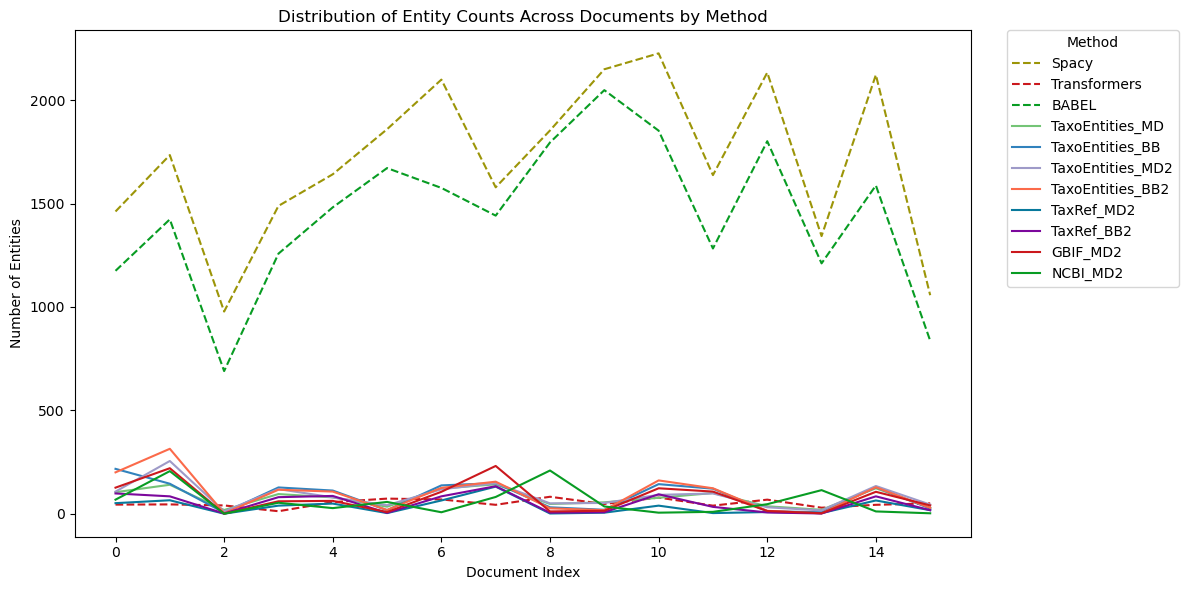

In [6]:
import matplotlib.ticker as ticker

color_mapping = {
    'BABEL': '#089c23',
    'Spacy': '#9c9508',
    'Transformers': '#cb181d',
    'TaxoEntities_MD': '#74c476',
    'TaxoEntities_BB': '#3182bd',
    'TaxoEntities_MD2': '#9e9ac8',
    'TaxoEntities_BB2': '#fb6a4a',
    'TaxRef_BB2': '#7c089c',
    'TaxRef_MD2': '#08799c',
    'GBIF_MD2': '#cb181d',
    'NCBI_MD2': '#089c23'
}

line_style_mapping = {
    'BABEL': '--',
    'Spacy': '--',
    'Transformers': '--',
    'TaxoEntities_MD': '-',
    'TaxoEntities_BB': '-',
    'TaxoEntities_MD2': '-',
    'TaxoEntities_BB2': '-',
    'TaxRef_BB2': '-',
    'TaxRef_MD2': '-',
    'GBIF_MD2': '-',
    'NCBI_MD2': '-'
}

plt.figure(figsize=(12, 6))

# Line plot for each method
for column in num_entities_df.columns:
    plt.plot(num_entities_df[column], label=column, color=color_mapping[column], linestyle=line_style_mapping[column])


plt.title('Distribution of Entity Counts Across Documents by Method')
plt.xlabel('Document Index')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylabel('Number of Entities')
plt.legend(title='Method', bbox_to_anchor=(1.04, 1), borderaxespad=0)

plt.tight_layout()
plt.savefig('C:/Users/maria/OneDrive/Documentos/Thesis/Report/NER_test_all_models.png')

plt.show()


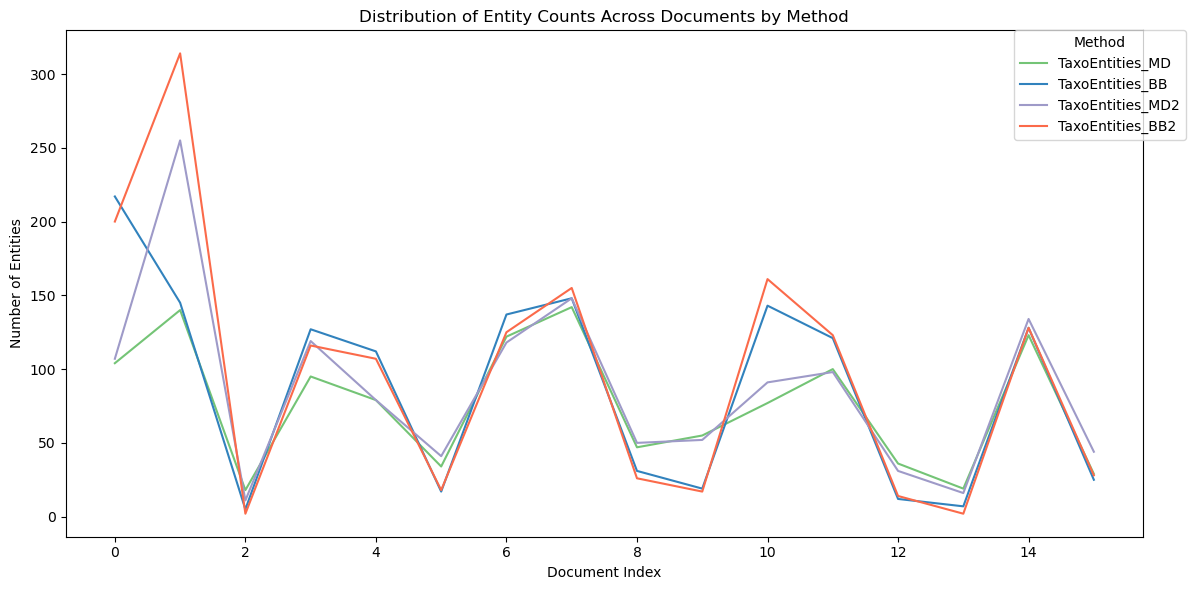

In [7]:
plt.figure(figsize=(12, 6))

columns_to_plot= ['TaxoEntities_MD', 'TaxoEntities_BB', 'TaxoEntities_MD2', 'TaxoEntities_BB2']
# Line plot for each method
for column in columns_to_plot:
    plt.plot(num_entities_df[column], label=column, color=color_mapping[column])

plt.title('Distribution of Entity Counts Across Documents by Method')
plt.xlabel('Document Index')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylabel('Number of Entities')
plt.legend(title='Method', bbox_to_anchor=(1.04, 1), borderaxespad=0)

plt.tight_layout()
plt.savefig('C:/Users/maria/OneDrive/Documentos/Thesis/Report/NER_test_taxoent.png')


plt.show()

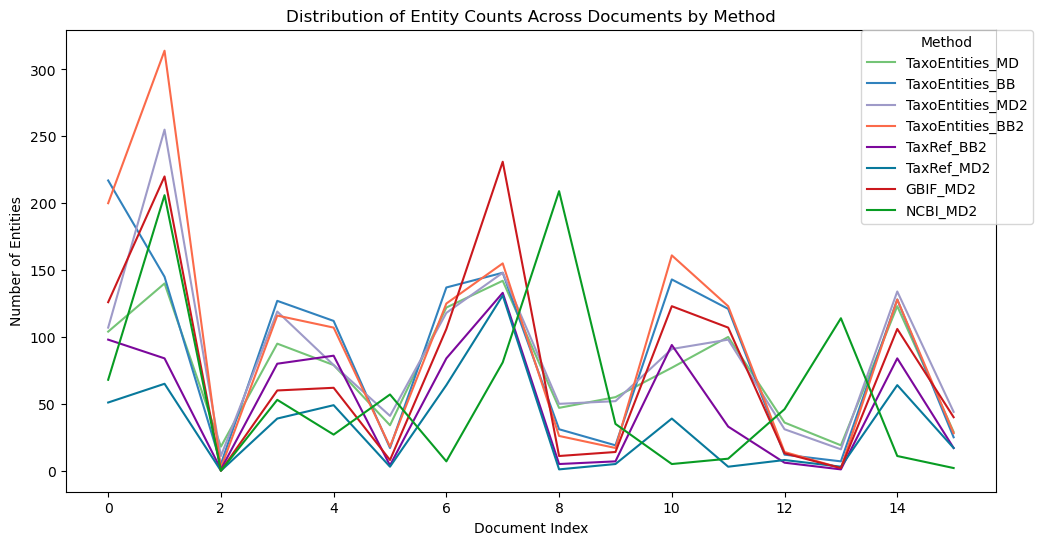

In [8]:
plt.figure(figsize=(12, 6))

columns_to_plot= ['TaxoEntities_MD', 'TaxoEntities_BB', 'TaxoEntities_MD2', 'TaxoEntities_BB2', 
                  'TaxRef_BB2', 
                  'TaxRef_MD2', 'GBIF_MD2', 'NCBI_MD2']

# Line plot for each method
for column in columns_to_plot:
    plt.plot(num_entities_df[column], label=column, color=color_mapping[column], linestyle=line_style_mapping[column])

plt.title('Distribution of Entity Counts Across Documents by Method')
plt.xlabel('Document Index')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylabel('Number of Entities')
plt.legend(title='Method', bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.show()


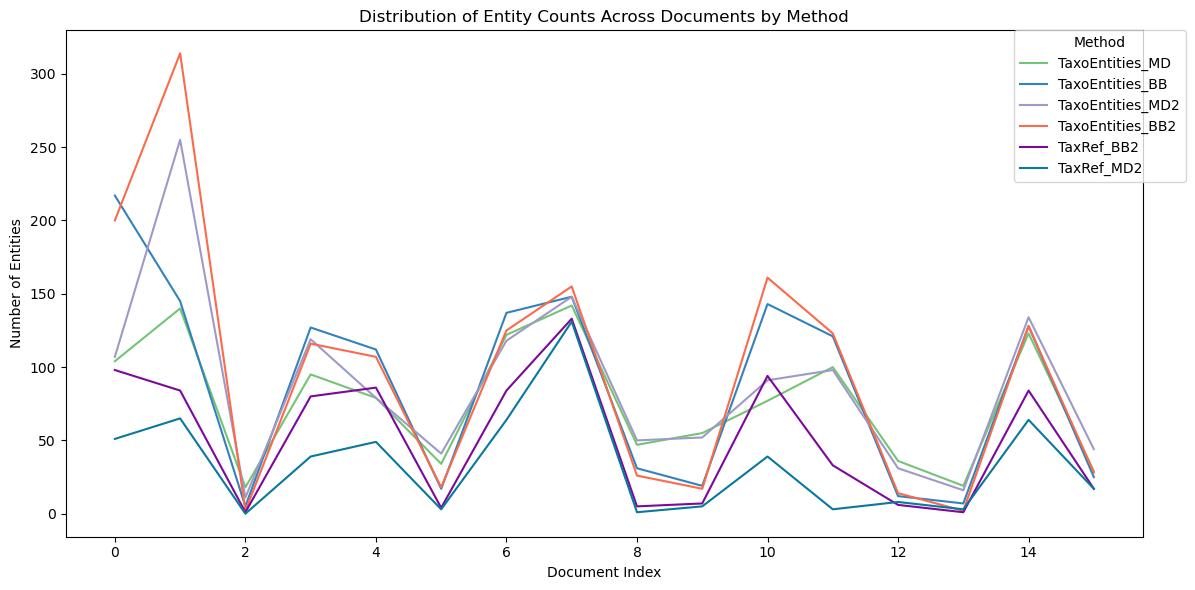

In [9]:
plt.figure(figsize=(12, 6))

columns_to_plot= ['TaxoEntities_MD', 'TaxoEntities_BB', 'TaxoEntities_MD2', 'TaxoEntities_BB2', 
                  'TaxRef_BB2', 
                  'TaxRef_MD2']

# Line plot for each method
for column in columns_to_plot:
    plt.plot(num_entities_df[column], label=column, color=color_mapping[column], linestyle=line_style_mapping[column])

plt.title('Distribution of Entity Counts Across Documents by Method')
plt.xlabel('Document Index')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylabel('Number of Entities')
plt.legend(title='Method', bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.tight_layout()
plt.savefig('C:/Users/maria/OneDrive/Documentos/Thesis/Report/NER_test_texomodels.png')
plt.show()

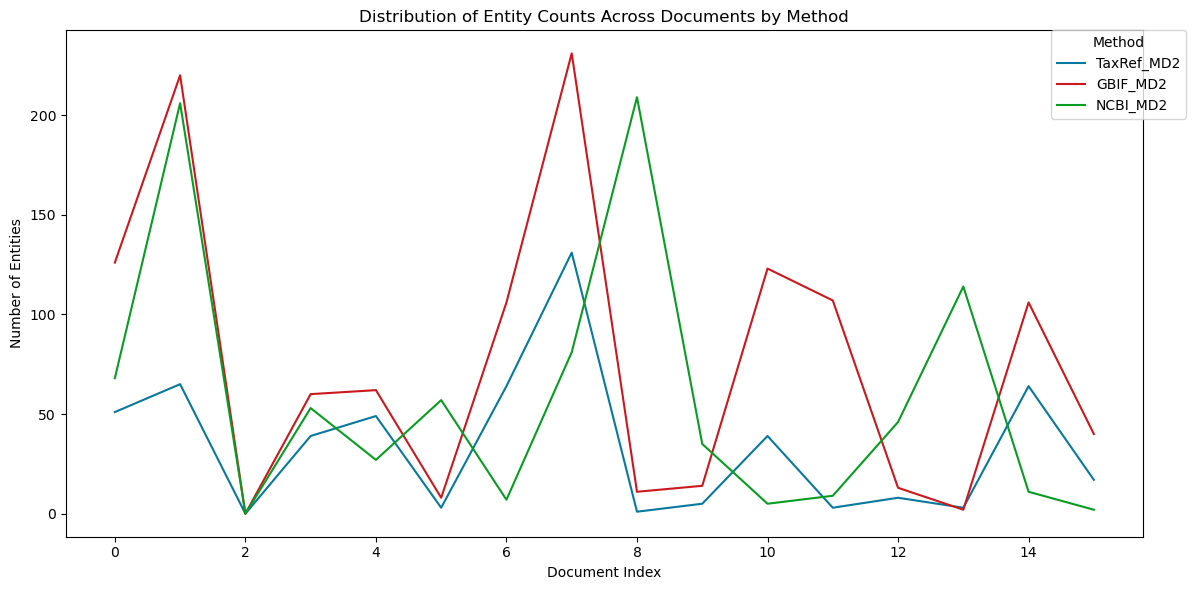

In [10]:
plt.figure(figsize=(12, 6))

columns_to_plot= [ 
    'TaxRef_MD2', 'GBIF_MD2', 'NCBI_MD2']

# Line plot for each method
for column in columns_to_plot:
    plt.plot(num_entities_df[column], label=column, color=color_mapping[column], linestyle=line_style_mapping[column])

plt.title('Distribution of Entity Counts Across Documents by Method')
plt.xlabel('Document Index')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylabel('Number of Entities')
plt.legend(title='Method', bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.tight_layout()
plt.savefig('C:/Users/maria/OneDrive/Documentos/Thesis/Report/NER_test_dbs.png')
plt.show()

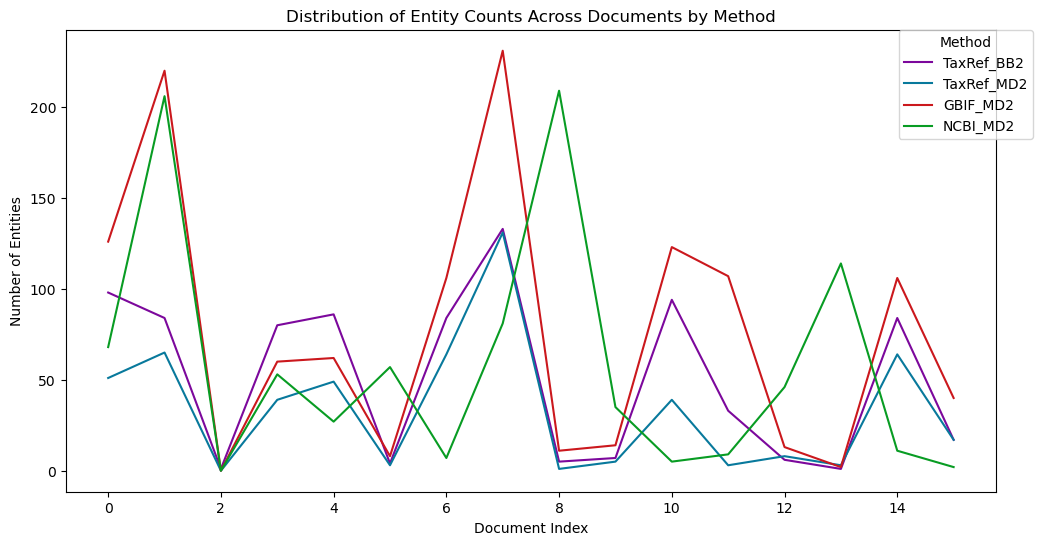

In [11]:
plt.figure(figsize=(12, 6))

columns_to_plot= ['TaxRef_BB2', 'TaxRef_MD2', 'GBIF_MD2', 'NCBI_MD2']
# Line plot for each method
for column in columns_to_plot:
    plt.plot(num_entities_df[column], label=column, color=color_mapping[column])

plt.title('Distribution of Entity Counts Across Documents by Method')
plt.xlabel('Document Index')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylabel('Number of Entities')
plt.legend(title='Method', bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.show()


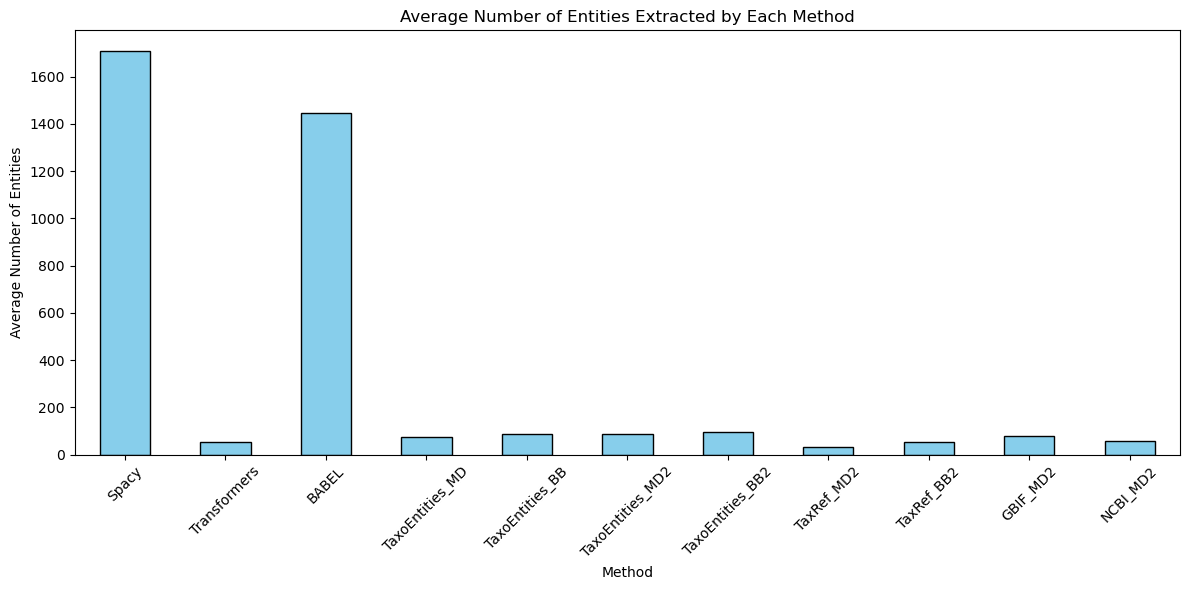

In [12]:


# Assuming num_entities_df is already computed and has the relevant columns

# Calculate the mean values for each column to show in the bar chart
mean_values = num_entities_df.mean()

# Creating a grouped bar chart
plt.figure(figsize=(12, 6))
mean_values.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Number of Entities Extracted by Each Method')
plt.xlabel('Method')
plt.ylabel('Average Number of Entities')
plt.xticks(rotation=45)  # Rotate the labels for readability
plt.tight_layout()
plt.show()


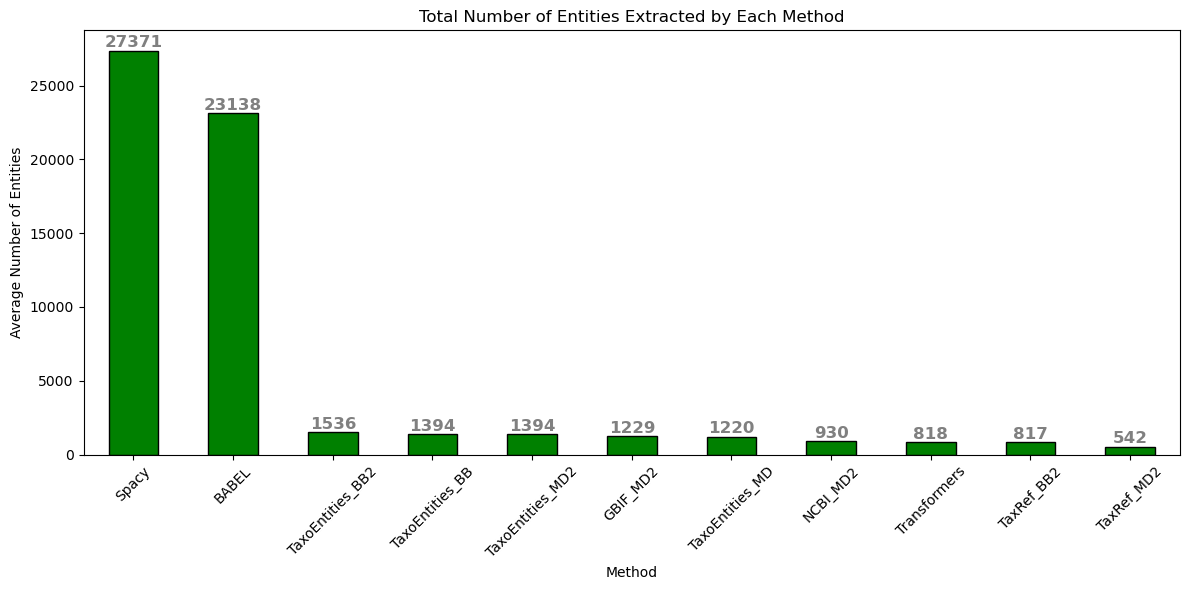

In [13]:
total_entities = num_entities_df.sum()

total_entities = total_entities.sort_values(ascending=False)
# Creating a grouped bar chart
plt.figure(figsize=(12, 6))
total_entities.plot(kind='bar', color='green', edgecolor='black')
plt.title('Total Number of Entities Extracted by Each Method')
plt.xlabel('Method')
plt.ylabel('Average Number of Entities')
plt.xticks(rotation=45)  # Rotate the labels for readability

# Adding totals at the top of the bars
for i, value in enumerate(total_entities):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=12, color='grey', weight='bold')
    
plt.tight_layout()
plt.show()

In [14]:
# Initialize an empty dictionary to store the results
unique_entities_count = {}

# Loop through each column in the DataFrame
for column in papers_20_counts_df.columns:
    try:
        # Flatten the list of lists or list of tuples in each column to a single list
        all_entities = [entity for sublist in papers_20_counts_df[column].dropna() for entity in sublist]

        # Convert to set to find unique entities, then count the length of the set
        unique_entities_count[column] = len(set(all_entities))

    except Exception as e:
        print(f"Error processing column {column}: {e}")

# Output the count of unique entities per column
for column, count in unique_entities_count.items():
    print(f"Total unique entities in {column}: {count}")

counts_df = pd.DataFrame(list(unique_entities_count.items()), columns=['Method', 'Total Unique Entities'])
counts_df = counts_df[counts_df['Method'] != 'fileMain_s']
counts_df

Total unique entities in fileMain_s: 31
Total unique entities in Spacy: 9728
Total unique entities in Transformers: 818
Total unique entities in BABEL: 7690
Total unique entities in TaxoEntities_MD: 671
Total unique entities in TaxoEntities_BB : 642
Total unique entities in TaxoEntities_MD2 : 762
Total unique entities in TaxoEntities_BB2: 653
Total unique entities in TaxRef_MD2: 208
Total unique entities in TaxRef_BB2 : 242
Total unique entities in GBIF_MD2 : 464
Total unique entities in NCBI_MD2: 320


,Method,Total Unique Entities
1,Spacy,9728
2,Transformers,818
3,BABEL,7690
4,TaxoEntities_MD,671
5,TaxoEntities_BB,642
6,TaxoEntities_MD2,762
7,TaxoEntities_BB2,653
8,TaxRef_MD2,208
9,TaxRef_BB2,242
10,GBIF_MD2,464


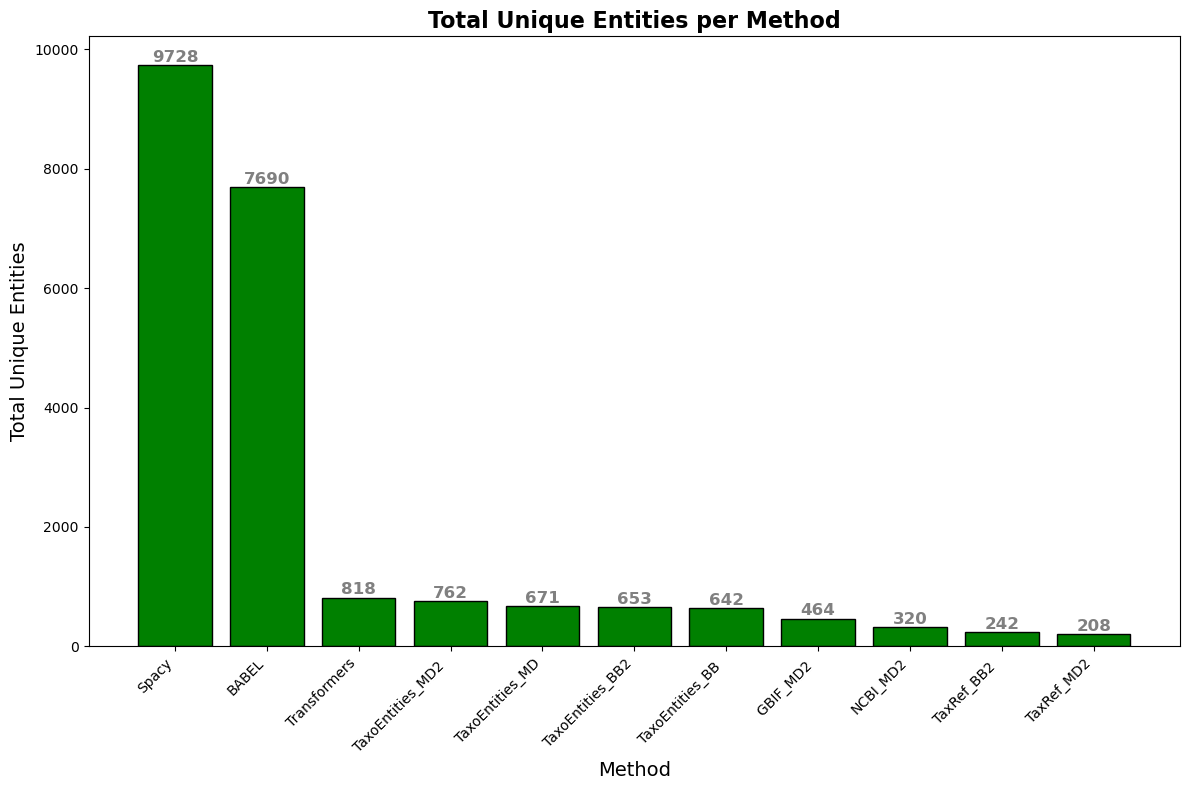

In [15]:
# Sort the DataFrame by 'Total Unique Entities' in descending order
counts_df_sorted = counts_df.sort_values(by='Total Unique Entities', ascending=False)

# Plotting the total unique entities per method
plt.figure(figsize=(12, 8))
plt.bar(counts_df_sorted['Method'], counts_df_sorted['Total Unique Entities'], color='green', edgecolor='black')
plt.xlabel('Method', fontsize=14)
plt.ylabel('Total Unique Entities', fontsize=14)
plt.title('Total Unique Entities per Method', fontsize=16, weight='bold')

# Adding totals at the top of the bars
for i, value in enumerate(counts_df_sorted['Total Unique Entities']):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=12, color='grey', weight='bold')

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


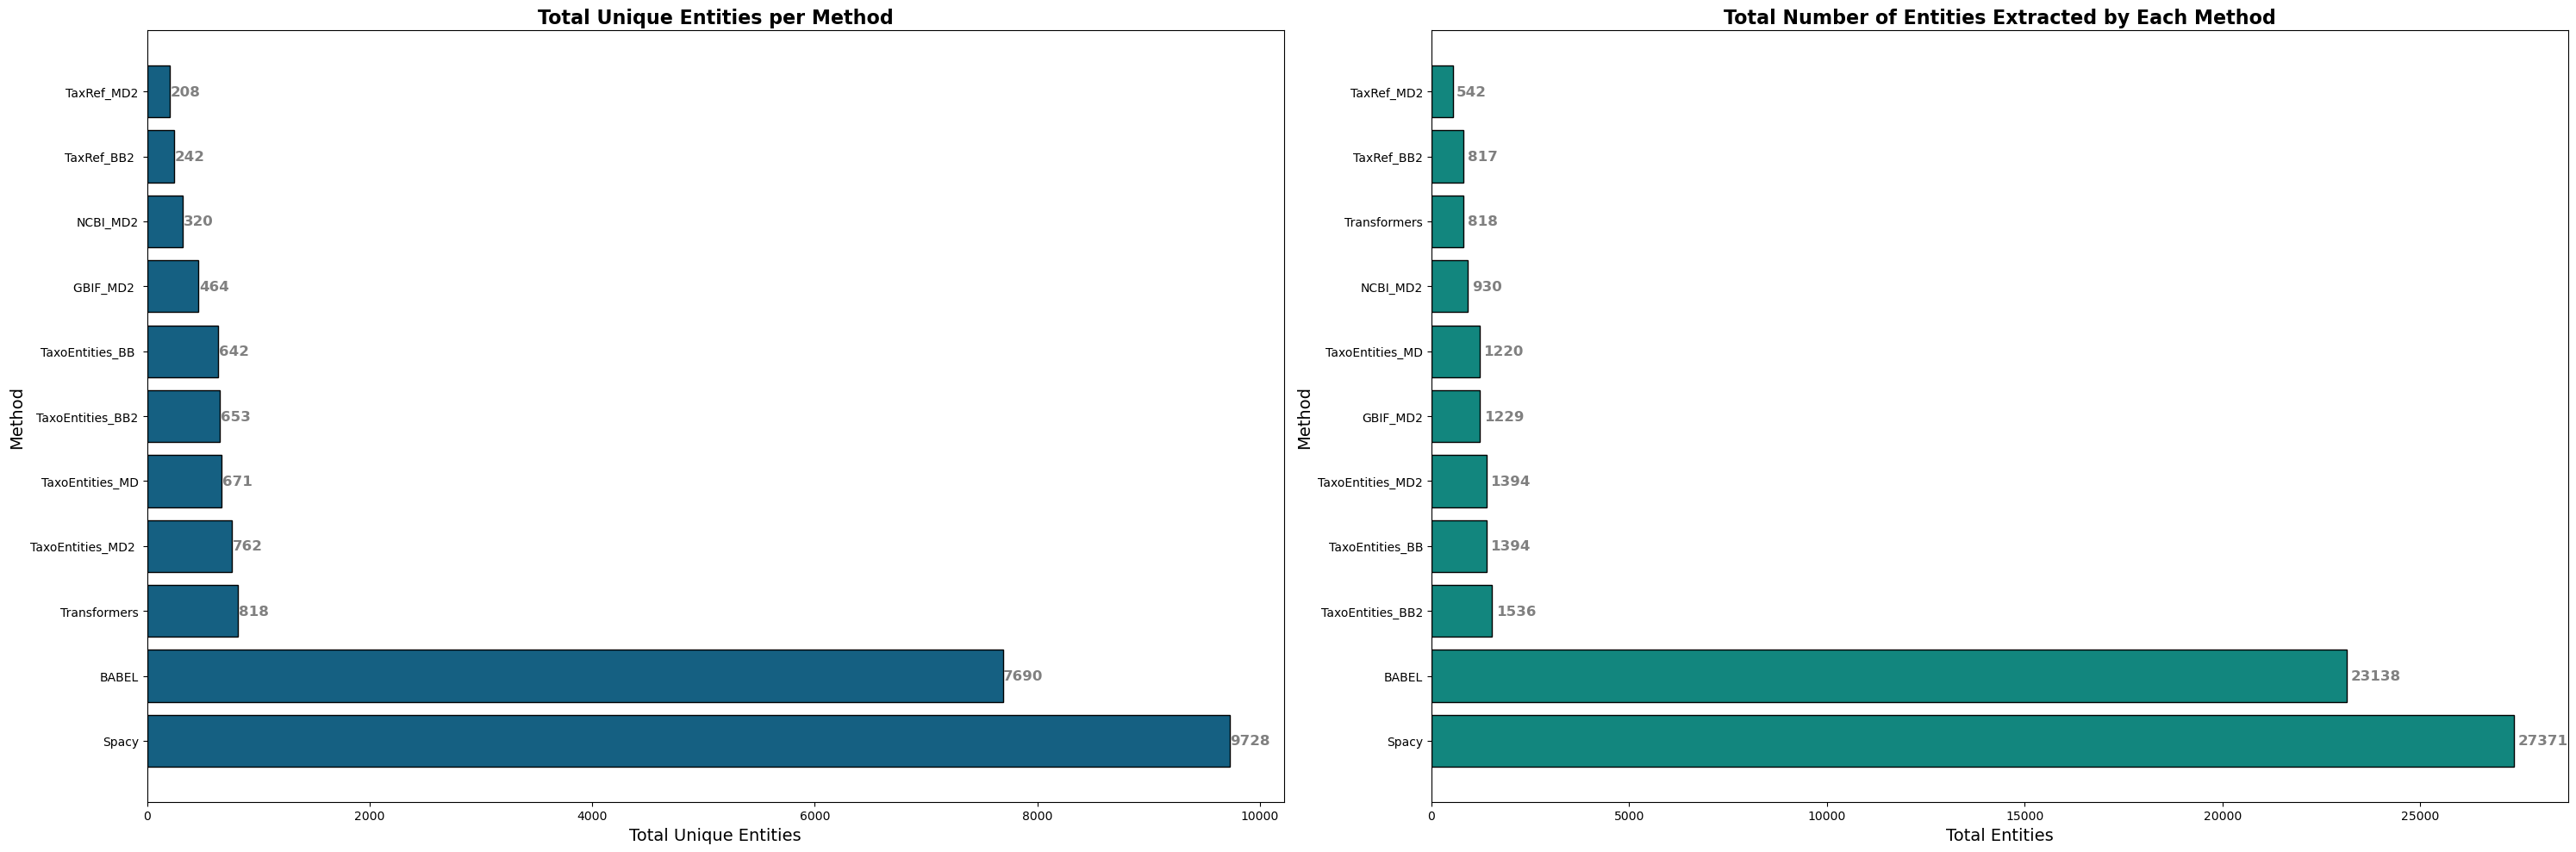

In [16]:
# Plotting side-by-side horizontal bar charts
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# Plotting the total unique entities per method as a horizontal bar chart
axs[0].barh(counts_df_sorted['Method'], counts_df_sorted['Total Unique Entities'], color='#156082', edgecolor='black')
axs[0].set_xlabel('Total Unique Entities', fontsize=14)
axs[0].set_ylabel('Method', fontsize=14)
axs[0].set_title('Total Unique Entities per Method', fontsize=16, weight='bold')

# Adding totals at the end of the bars
for i, value in enumerate(counts_df_sorted['Total Unique Entities']):
    axs[0].text(value + 5, i, str(value), va='center', fontsize=12, color='grey', weight='bold')

# Plotting the total number of entities extracted by each method as a horizontal bar chart
axs[1].barh(total_entities.index, total_entities.values, color='#12867E', edgecolor='black')
axs[1].set_xlabel('Total Entities', fontsize=14)
axs[1].set_ylabel('Method', fontsize=14)
axs[1].set_title('Total Number of Entities Extracted by Each Method', fontsize=16, weight='bold')

# Adding totals at the end of the bars
for i, value in enumerate(total_entities.values):
    axs[1].text(value + 100, i, str(value), va='center', fontsize=12, color='grey', weight='bold')

    
plt.tight_layout()
plt.savefig('C:/Users/maria/OneDrive/Documentos/Thesis/Report/NER_counts.png')

plt.tight_layout()
plt.show()

## GBIF MD2 Results on Papers dataset

In [16]:
file_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/papers_v3_basics.csv'
papers_df = pd.read_csv(file_path)
papers_df

,fileMain_s,numChunks,Chunks_BERTopics,Topic_Counter,Topic_Percentage,TaxoEntitiesMD2_GBIF,TaxoEntities_Count,Species_Count,kingdom_tuple_Count,phylum_tuple_Count,...,order_tuple_Count,family_tuple_Count,genus_tuple_Count,species_tuple_Count,Parsed_TopicsLDA,releasedDateY_i,Gender_Numeric_Avg,First_Gender_Value,Last_Gender_Value,Gender_Counts
0,https://cnrs.hal.science/hal-03755748/document,1,[61],{'B61': 1},{'B61': 100.0},[],Counter(),[],[],[],...,[],[],[],[],"{'L4': 25, 'L10': 19, 'L12': 8, 'L21': 22, 'L3...",2022,-0.555556,1.0,-1.0,"{'female': 2, 'male': 2, 'unknown': 2}"
1,https://hal.science/hal-01296551/document,1,[-1],{'B-1': 1},{'B-1': 100.0},[],Counter(),[],[],[],...,[],[],[],[],"{'L29': 4, 'L30': 5, 'L32': 7, 'L47': 67, 'L57...",2016,-0.333333,1.0,-1.0,"{'male': 6, 'female': 4, 'unknown': 1, 'mostly..."
2,https://hal.science/hal-00870744/document,1,[-1],{'B-1': 1},{'B-1': 100.0},[],Counter(),[],[],[],...,[],[],[],[],"{'L19': 6, 'L30': 7, 'L47': 85}",2013,-1.000000,-1.0,-1.0,"{'female': 1, 'male': 1}"
3,https://hal.science/hal-00949680/document,1,[5],{'B5': 1},{'B5': 100.0},[],Counter(),[],[],[],...,[],[],[],[],"{'L21': 5, 'L38': 16, 'L46': 13, 'L50': 64}",2014,0.000000,-1.0,0.0,{'female': 2}
4,https://hal.inrae.fr/hal-02699278/document,1,[-1],{'B-1': 1},{'B-1': 100.0},"[[('GBIF:3042', 'aphid', 1.0), ('GBIF:4386623'...","Counter({('GBIF:3042', 'aphid'): 2, ('GBIF:438...","[Counter({('GBIF:2069580', 'Rhopalosiphum padi...","[(('GBIF:1', 'Animalia'), 4)]","[(('GBIF:54', 'Arthropoda'), 4)]",...,"[(('GBIF:809', 'Hemiptera'), 4)]","[(('GBIF:3042', 'Aphididae'), 4)]","[(('GBIF:2069512', 'Rhopalosiphum'), 4)]","[(('GBIF:2069580', 'Rhopalosiphum padi'), 4)]","{'L9': 11, 'L19': 8, 'L38': 6, 'L39': 32, 'L56...",2020,-0.833333,-0.5,-1.0,"{'male': 7, 'female': 7}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,https://hal.science/hal-03362851/document,47,"[60, 2, 2, 2, 2, -1, 2, 2, -1, 1, 1, -1, -1, -...","{'B60': 1, 'B2': 26, 'B-1': 10, 'B1': 4, 'B22'...","{'B60': 2.127659574468085, 'B2': 55.3191489361...","[[('GBIF:1673043', 'Synthesia', 0.906332910060...","Counter({('GBIF:2878688', 'Quercus robur'): 2,...","[Counter({('GBIF:2878688', 'Quercus robur'): 2...","[(('GBIF:6', 'Plantae'), 331)]","[(('GBIF:7707728', 'Tracheophyta'), 331)]",...,"[(('GBIF:1354', 'Fagales'), 82), (('GBIF:691',...","[(('GBIF:5015', 'Rosaceae'), 61), (('GBIF:4689...","[(('GBIF:2877951', 'Quercus'), 27), (('GBIF:28...","[(('GBIF:2882316', 'Fagus sylvatica'), 18), ((...","{'L8': 4, 'L17': 8, 'L21': 72, 'L38': 2, 'L48'...",2021,-0.442308,1.0,-1.0,"{'female': 4, 'mostly_female': 1, 'male': 2, '..."
1004,https://hal.science/hal-03004624/document,54,"[5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1...","{'B5': 1, 'B-1': 45, 'B4': 5, 'B1': 1, 'B40': ...","{'B5': 1.8518518518518516, 'B-1': 83.333333333...","[[('GBIF:2440735', 'Balaenoptera musculus', 1....","Counter({('GBIF:5888', 'white sharks'): 2, ('G...","[Counter({('GBIF:2440735', 'Balaenoptera muscu...","[(('GBIF:1', 'Animalia'), 70), (('GBIF:6', 'Pl...","[(('GBIF:44', 'Chordata'), 69), (('GBIF:54', '...",...,"[(('GBIF:732', 'Carnivora'), 18), (('GBIF:731'...","[(('GBIF:9701', 'Canidae'), 18), (('GBIF:5240'...","[(('GBIF:5219142', 'Canis'), 18), (('GBIF:2481...","[(('GBIF:5219173', 'Canis lupus'), 18), (('GBI...","{'L12': 4, 'L14': 8, 'L16': 1, 'L18': 2, 'L29'...",2020,-0.642857,-1.0,-0.5,"{'female': 3, 'male': 5}"
1005,https://hal.inrae.fr/hal-04429206/document,57,"[60, 2, 60, 2, 2, 2, 2, 2, 2, -1, -1, 1, -1, 2...","{'B60': 2, 'B2': 17, 'B-1': 36, 'B1': 1, 'B14'...","{'B60': 3.508771929824561, 'B2': 29.8245614035...","[[('GBIF:4597213', 'Wolfgangia', 0.70422244071...","Counter({('GBIF:2382506', 'Gorete'): 3, ('GBIF...","[Counter({('GBIF:2482552', 'Chough'): 1}), Cou...","[(('GBIF:1', 'Animalia'), 9), (('GBIF:6', 'Pla...","[(('GBIF:44', 'Chordata'), 9), (('GBIF:7707728...",...,"[(('GBIF:587', 'Perciformes'), 3), (('GBIF:729...","[(('GBIF:4276', 'Haemulidae'), 3), 

In [65]:
def parse_counter_string(counter_str):
    try:
        # Remove the outer brackets
        counter_str = counter_str.strip("[]")
        
        # Split the string into individual Counter representations
        pattern = r'Counter\({.*?}\)'
        counter_parts = re.findall(pattern, counter_str)
        
        # Initialize a total counter
        total_counter = Counter()
        
        # Parse each Counter representation and update the total counter
        for part in counter_parts:
            # Clean the part and parse it
            clean_part = part.replace("Counter(", "").rstrip(")")
            part_counter = ast.literal_eval(clean_part)
            total_counter.update(part_counter)
        
        return total_counter
    except Exception as e:
        print(f"Error parsing counter string: {e}")
        return Counter()

# Apply the conversion to the entire 'Species_Count' column
papers_df['Species_Count_Counter'] = papers_df['TaxoEntities_Count'].apply(parse_counter_string)


In [66]:
type(papers_df['Species_Count_Counter'].iloc[1007])

collections.Counter

In [67]:
all_keys = set()

for counter in papers_df['Species_Count_Counter']:
    all_keys.update(counter.keys())

all_keys_list = list(all_keys)
all_keys_list

[('GBIF:7931398', 'Melampyrum sylvaticum'),
 ('GBIF:3013045', 'Sorbus badensis Düll'),
 ('GBIF:2510', 'Adoxaceae'),
 ('GBIF:2383673', 'Leopard wrasse'),
 ('GBIF:8549', 'Nototheniidae'),
 ('GBIF:9615851', '? dorotheae'),
 ('GBIF:2385955', 'Antarctic cod'),
 ('GBIF:5314764', 'Serapias vomeracea'),
 ('GBIF:2481181', 'yellow-legged gull'),
 ('GBIF:1334163', 'Alloxysta'),
 ('GBIF:9209165', 'Sedum telephium'),
 ('GBIF:1028151', 'Glomeris intermedia'),
 ('GBIF:2439134', 'Clethrionomys'),
 ('GBIF:3204558', 'Spirostomum teres'),
 ('GBIF:3210401', 'Nebela'),
 ('GBIF:7827588', 'Sorghum bicolor'),
 ('GBIF:9316', 'gull'),
 ('GBIF:7192', 'Scomberesocidae'),
 ('GBIF:3253427', 'Pilosa'),
 ('GBIF:6181702', 'Stramonita haemastoma floridana'),
 ('GBIF:1050040', 'Acarina'),
 ('GBIF:9113320', 'Lepidosperma calcicola'),
 ('GBIF:2337608', 'Siluris glanis'),
 ('GBIF:8909809', 'Emys orbicularis'),
 ('GBIF:5216276', 'Pristis pristis'),
 ('GBIF:8006204', 'Cajanus'),
 ('GBIF:9809568', 'Megaptera novaeangliae'),
 

In [68]:
len(all_keys_list)

19670

In [69]:
type(all_keys_list[0])

tuple

In [70]:
# Calculate the total count of all keys, including duplicates
total_key_count = sum(len(counter) for counter in papers_df['Species_Count_Counter'])

print(total_key_count)


37739


Total sum of all entity counts: 96926
Total number of unique entity keys: 19670


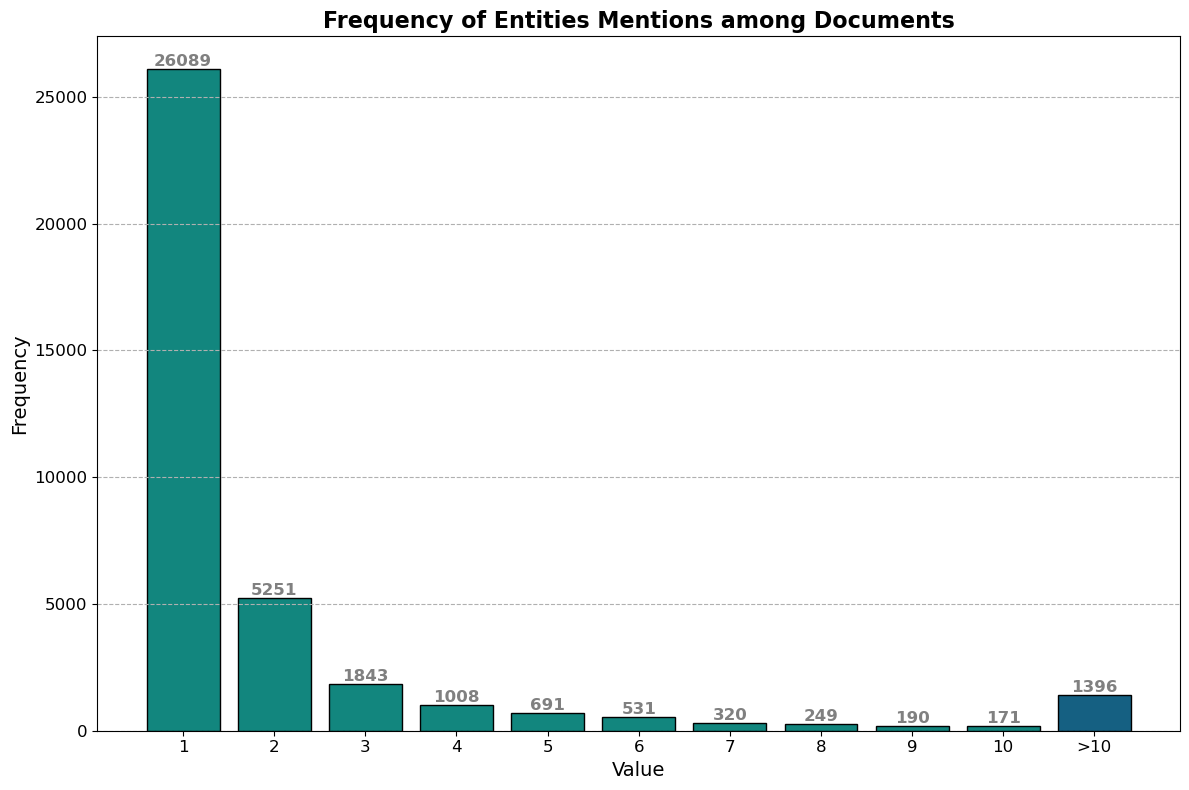

In [71]:
# Define the threshold value for plotting
threshold = 10

# Create a Counter to aggregate all counts and to count the frequency of values
total_entity_counts = Counter()
value_frequency = Counter()

for counter in papers_df['Species_Count_Counter']:
    total_entity_counts.update(counter)
    for value in counter.values():
        value_frequency[value] += 1

# Total sum of all entity counts
total_sum_of_counts = sum(total_entity_counts.values())

# Total number of unique entity keys
unique_entity_keys_count = len(total_entity_counts)

# Print the results
print("Total sum of all entity counts:", total_sum_of_counts)
print("Total number of unique entity keys:", unique_entity_keys_count)

# Plotting the frequency of each value across counters
# Group counts above the threshold
grouped_values = {k: v for k, v in value_frequency.items() if k <= threshold}
grouped_values[f'>{threshold}'] = sum(v for k, v in value_frequency.items() if k > threshold)

# Sort the keys so that the '>threshold' group appears at the end
sorted_keys = sorted([k for k in grouped_values if isinstance(k, int)]) + [f'>{threshold}']
sorted_values = [grouped_values[k] for k in sorted_keys]

# Determine colors for each bar
colors = ['#12867E' if k != f'>{threshold}' else '#156082' for k in sorted_keys]

plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(sorted_keys)), sorted_values, color=colors, edgecolor='black')

# Adding totals at the top of the bars
for bar, value in zip(bars, sorted_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom', fontsize=12, color='grey', weight='bold')

plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Frequency of Entities Mentions among Documents', fontsize=16, weight='bold')
plt.xticks(range(len(sorted_keys)), labels=sorted_keys, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

plt.savefig('C:/Users/maria/OneDrive/Documentos/Thesis/Report/NER_frequencies.png')

plt.show()

In [72]:
# Define the function to receive a list of counters and return the number of unique elements
def count_unique_elements(counter_list):
    all_entities = Counter()
    for counter in counter_list:
        all_entities.update(counter)
    return len(all_entities)

# Apply the function to papers_df['Species_Count_Counter'] and save the result in papers_df['numEntities']
papers_df['numEntities'] = papers_df['Species_Count_Counter'].apply(lambda x: count_unique_elements([x]))
papers_df.sort_values(by='numEntities').head(60)

,fileMain_s,numChunks,Chunks_BERTopics,Topic_Counter,Topic_Percentage,TaxoEntitiesMD2_GBIF,TaxoEntities_Count,Species_Count,kingdom_tuple_Count,phylum_tuple_Count,...,genus_tuple_Count,species_tuple_Count,Parsed_TopicsLDA,releasedDateY_i,Gender_Numeric_Avg,First_Gender_Value,Last_Gender_Value,Gender_Counts,Species_Count_Counter,numEntities
0,https://cnrs.hal.science/hal-03755748/document,1,[61],{'B61': 1},{'B61': 100.0},[],Counter(),[],[],[],...,[],[],"{'L4': 25, 'L10': 19, 'L12': 8, 'L21': 22, 'L3...",2022,-0.555556,1.0,-1.0,"{'female': 2, 'male': 2, 'unknown': 2}",{},0
836,https://hal.sorbonne-universite.fr/hal-0326598...,23,"[5, 14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1...","{'B5': 1, 'B14': 1, 'B-1': 21}","{'B5': 4.3478260869565215, 'B14': 4.3478260869...",[],Counter(),[],[],[],...,[],[],"{'L33': 2, 'L58': 1, 'L64': 97}",2021,-1.000000,-1.0,-1.0,"{'female': 3, 'male': 3}",{},0
79,https://hal.sorbonne-universite.fr/hal-0134706...,10,"[5, 1, 1, 1, 1, 1, 1, 1, 1, 1]","{'B5': 1, 'B1': 9}","{'B5': 10.0, 'B1': 90.0}",[],Counter(),[],[],[],...,[],[],"{'L10': 3, 'L17': 74, 'L26': 4, 'L51': 5, 'L64...",2016,-0.333333,-1.0,1.0,{'male': 4},{},0
60,https://hal.science/hal-04241279/document,10,"[5, 52, 52, 52, 52, 52, 52, -1, 11, 11]","{'B5': 1, 'B52': 6, 'B-1': 1, 'B11': 2}","{'B5': 10.0, 'B52': 60.0, 'B-1': 10.0, 'B11': ...",[],Counter(),[],[],[],...,[],[],"{'L0': 5, 'L1': 17, 'L12': 9, 'L18': 12, 'L23'...",2023,-0.428571,-1.0,-1.0,"{'male': 3, 'female': 1}",{},0
248,https://hal.science/hal-02331167/document,14,"[5, 33, 33, 33, -1, 33, 33, 33, 33, 33, 33, 33...","{'B5': 1, 'B33': 12, 'B-1': 1}","{'B5': 7.142857142857142, 'B33': 85.7142857142...",[],Counter(),[],[],[],...,[],[],"{'L2': 2, 'L16': 8, 'L31': 1, 'L48': 2, 'L64':...",2020,-1.000000,-1.0,-1.0,"{'male': 3, 'female': 2}",{},0
217,https://hal.science/hal-02413061/document,14,"[5, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12...","{'B5': 1, 'B12': 13}","{'B5': 7.142857142857142, 'B12': 92.8571428571...",[],Counter(),[],[],[],...,[],[],"{'L5': 2, 'L12': 9, 'L29': 52, 'L34': 7, 'L35'...",2021,-0.714286,-1.0,-1.0,"{'male': 3, 'female': 1}",{},0
539,https://hal.science/hal-02350650/document,18,"[5, 3, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,...","{'B5': 1, 'B3': 1, 'B33': 15, 'B-1': 1}","{'B5': 5.555555555555555, 'B3': 5.555555555555...",[],Counter(),[],[],[],...,[],[],"{'L3': 4, 'L5': 7, 'L16': 17, 'L48': 4, 'L64':...",2019,-1.000000,-1.0,-1.0,{'female': 4},{},0
36,https://hal.science/hal-04164752/document,7,"[-1, -1, -1, -1, -1, -1, -1]",{'B-1': 7},{'B-1': 100.0},[],Counter(),[],[],[],...,[],[],"{'L11': 42, 'L27': 3, 'L37': 29, 'L47': 8, 'L4...",2023,0.000000,-1.0,1.0,"{'male': 3, 'unknown': 1}",{},0
161,https://hal.inrae.fr/hal-03263516/document,13,"[14, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1]","{'B14': 1, 'B-1': 8, 'B1': 4}","{'B14': 7.6923076923076925, 'B-1': 61.53846153...",[],Counter(),[],[],[],...,[],[],"{'L16': 18, 'L17': 3, 'L38': 8, 'L67': 71}",2021,-0.916667,-1.0,-1.0,"{'male': 1, 'female': 2}",{},0
726,https://hal.science/hal-02350603/document,20,"[-1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1...","{'B-1': 19, 'B4': 1}","{'B-1': 95.0, 'B4': 5.0}",[],Counter(),[],[],[],...,[],[],"{'L0': 1, 'L12': 31, 'L43': 6, 'L52': 8, 'L53'...",2019,0.000000,1.0,-1.0,"{'male': 3, 'female': 4, 'mostly_male': 1}",{},0


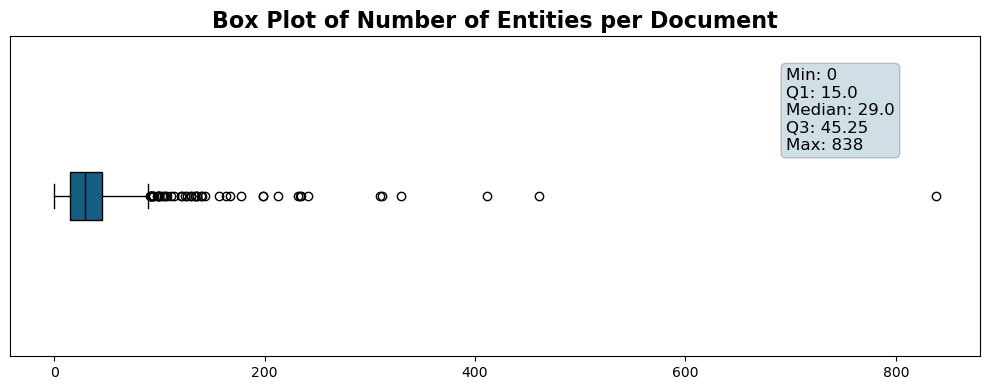

In [111]:
# Plotting the distribution of values in papers_df['numEntities'] as a box plot with a text box for relevant values
plt.figure(figsize=(10, 4))
plt.boxplot(papers_df['numEntities'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='#156082', color='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

# Adding titles and labels
plt.title('Box Plot of Number of Entities per Document', fontsize=16, weight='bold')
plt.gca().axes.get_yaxis().set_visible(False)

# Calculate relevant values for the text box
min_val = papers_df['numEntities'].min()
q1 = papers_df['numEntities'].quantile(0.25)
median_val = papers_df['numEntities'].median()
q3 = papers_df['numEntities'].quantile(0.75)
max_val = papers_df['numEntities'].max()

# Create the text box content
textstr = f'Min: {min_val}\nQ1: {q1}\nMedian: {median_val}\nQ3: {q3}\nMax: {max_val}'

# Add the text box to the plot
props = dict(boxstyle='round', facecolor='#156082', alpha=0.2)
plt.gca().text(0.8, 0.9, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

# Show the plot
plt.tight_layout()
plt.savefig('C:/Users/maria/OneDrive/Documentos/Thesis/Report/NER_num_entities_frequencies2.png')

plt.show()


In [98]:
### Define the threshold value for plotting
threshold = 30

# Create a Counter to count the frequency of values in papers_df['numEntities']
value_frequency = Counter(papers_df['numEntities'])

# Group counts above the threshold
grouped_values = {k: v for k, v in value_frequency.items() if k <= threshold}
grouped_values[f'>{threshold}'] = sum(v for k, v in value_frequency.items() if k > threshold)

# Sort the keys so that the '>threshold' group appears at the end
sorted_keys = sorted([k for k in grouped_values if isinstance(k, int)]) + [f'>{threshold}']
sorted_values = [grouped_values[k] for k in sorted_keys]

# Determine colors for each bar
colors = ['#12867E' if k != f'>{threshold}' else '#156082' for k in sorted_keys]


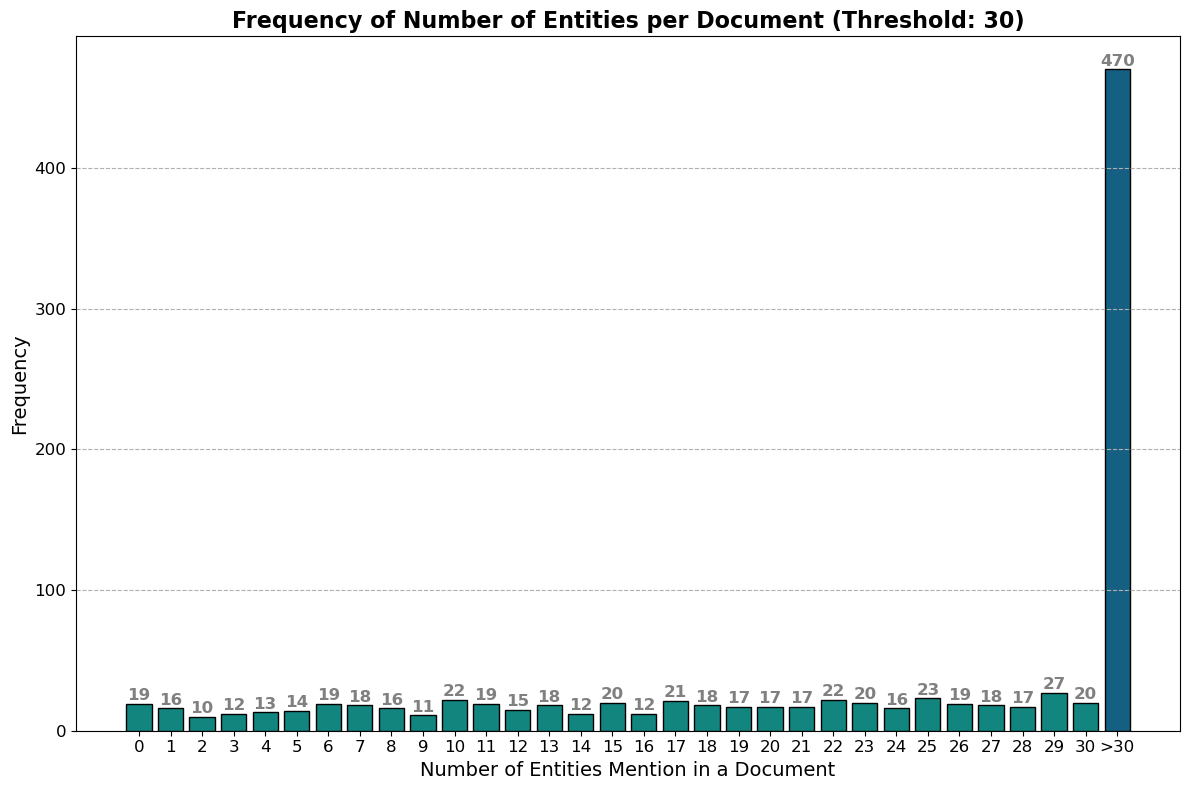

In [99]:

plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(sorted_keys)), sorted_values, color=colors, edgecolor='black')

# Adding totals at the top of the bars
for bar, value in zip(bars, sorted_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom', fontsize=12, color='grey', weight='bold')

plt.xlabel('Number of Entities Mentioned in a Document', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Number of Entities per Document (Threshold: {threshold})', fontsize=16, weight='bold')
plt.xticks(range(len(sorted_keys)), labels=sorted_keys, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

plt.savefig('C:/Users/maria/OneDrive/Documentos/Thesis/Report/NER_num_entities_frequencies.png')

plt.show()


## GBIF Querying analysis

In [2]:
file_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_GBIF.csv'
gbif_df = pd.read_csv(file_path)
gbif_df

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
0,GBIF:1,Animalia,NaN,NaN,Animalia,Animalia,KINGDOM,NaN,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GBIF:1000,scorpionfly,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
2,GBIF:1000,Mecoptera,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
3,GBIF:1000091,Methanobacterium,NaN,NaN,"Methanobacterium Kluyver & van Niel, 1936",Methanobacterium,GENUS,NaN,NaN,NaN,...,NaN,2,10895798.0,293.0,1192.0,3801.0,1000091.0,NaN,NaN,Methanobacteria
4,GBIF:1000182,Bacterium,NaN,NaN,"Halobacterium Elazari-Volcani, 1957",Halobacterium,GENUS,NaN,NaN,NaN,...,NaN,2,10764301.0,160.0,565.0,3802.0,1000182.0,NaN,NaN,Halobacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,GBIF:9980809,Spilomelinae,NaN,NaN,Spilomelinae,Spilomelinae,GENUS,NaN,NaN,NaN,...,NaN,1,54.0,216.0,797.0,8841.0,9980809.0,NaN,NaN,Insecta
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,Spinturnix andegavinus,1,54.0,367.0,1109.0,4549059.0,4407627.0,NaN,9982023.0,Arachnida
21594,GBIF:9990095,Curruca melanocephala,NaN,NaN,"Curruca melanocephala (J.F.Gmelin, 1789)",Curruca melanocephala,SPECIES,NaN,NaN,NaN,...,Curruca melanocephala,1,44.0,212.0,729.0,5285.0,7988924.0,NaN,9990095.0,Aves
21595,GBIF:9991963,Aphaenogaster rudis,NaN,NaN,Aphaenogaster rudis,Aphaenogaster rudis,SPECIES,NaN,NaN,NaN,...,Aphaenogaster rudis,1,54.0,216.0,1457.0,4342.0,1315863.0,NaN,9991963.0,Insecta


In [15]:
id_unique_count = gbif_df['gbif_id'].nunique()
name_unique_count = gbif_df['name'].nunique()
print(f'Unique ID cases {id_unique_count}, Unique name cases {name_unique_count}')

Unique ID cases 18746, Unique name cases 15987


In [49]:
# Create gbif_entities_list as a list of tuples (gbif_id, name)
gbif_entities_list = list(zip(gbif_df['gbif_id'], gbif_df['name']))

gbif_entities_list

[('GBIF:1', 'Animalia'),
 ('GBIF:1000', 'scorpionfly'),
 ('GBIF:1000', 'Mecoptera'),
 ('GBIF:1000091', 'Methanobacterium'),
 ('GBIF:1000182', 'Bacterium'),
 ('GBIF:1000326', 'Methanococcoides'),
 ('GBIF:1000372', 'Methanogenium'),
 ('GBIF:1000410', 'Methanogenium frigidum'),
 ('GBIF:1000426', 'Hexarthra'),
 ('GBIF:1000447', 'Hexarthra mira'),
 ('GBIF:1000581', 'Rotifer'),
 ('GBIF:10008615', 'Nu Bonifácio & Menot, 2018'),
 ('GBIF:1001202', 'Habrotrocha angusticollis'),
 ('GBIF:1001916', 'Asplanchna'),
 ('GBIF:1001917', 'Asplanchna girodi'),
 ('GBIF:1002167', 'Lecane'),
 ('GBIF:10022704', 'Stenus convergens convergens'),
 ('GBIF:10022854', 'Schizophyllum'),
 ('GBIF:1002486', 'Lecane inermis'),
 ('GBIF:10026259', 'Mycobacterium tuberculosis'),
 ('GBIF:1002648', 'Keratella quadrata (Müller, 1786)'),
 ('GBIF:10027232', 'Polysiphonia harveyi'),
 ('GBIF:10028909', 'Cerceris'),
 ('GBIF:1002993', 'Itura'),
 ('GBIF:1003', 'Trichoptera'),
 ('GBIF:1003', 'caddisflies'),
 ('GBIF:1003', 'caddisfly')

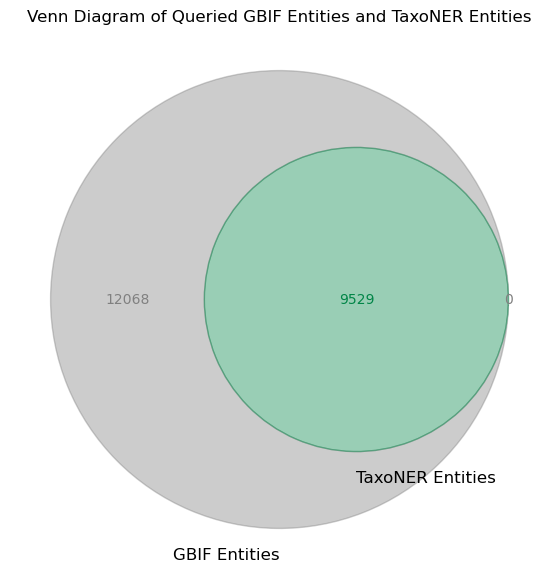

In [57]:
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Convert lists to sets for the Venn diagram
gbif_entities_set = set(gbif_entities_list)
all_keys_set = set(all_keys_list)

# Ensure the directory exists
output_directory = 'C:/Users/maria/OneDrive/Documentos/Thesis/Report'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Create the Venn diagram with specified colors
plt.figure(figsize=(10, 7))
venn = venn2(
    [gbif_entities_set, all_keys_set], 
    ('GBIF Entities', 'TaxoNER Entities')
)

# Set colors for the diagram
venn.get_label_by_id('10').set_color('grey')
venn.get_label_by_id('01').set_color('grey')
venn.get_label_by_id('11').set_color('#018547')
venn.get_patch_by_id('10').set_color('grey')
venn.get_patch_by_id('01').set_color('grey')
venn.get_patch_by_id('11').set_color('#018547')

plt.title('Venn Diagram of Queried GBIF Entities and TaxoNER Entities')
plt.savefig(os.path.join(output_directory, 'NER_venn_gbif_taxo.png'))

plt.show()


In [100]:
# Filter the rows where the tuples from all_keys match (gbif_df['gbif_id'], gbif_df['name'])
filtered_gbif_df = gbif_df[gbif_df.apply(lambda row: (row['gbif_id'], row['name']) in all_keys_list, axis=1)]

filtered_gbif_df

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
0,GBIF:1,Animalia,NaN,NaN,Animalia,Animalia,KINGDOM,NaN,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GBIF:1000,scorpionfly,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
2,GBIF:1000,Mecoptera,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
3,GBIF:1000091,Methanobacterium,NaN,NaN,"Methanobacterium Kluyver & van Niel, 1936",Methanobacterium,GENUS,NaN,NaN,NaN,...,NaN,2,10895798.0,293.0,1192.0,3801.0,1000091.0,NaN,NaN,Methanobacteria
5,GBIF:1000326,Methanococcoides,NaN,NaN,"Methanococcoides Sowers & Ferry, 1985",Methanococcoides,GENUS,NaN,NaN,NaN,...,NaN,2,10764301.0,10751195.0,1194.0,7791.0,1000326.0,NaN,NaN,Methanosarcinia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,GBIF:9980658,Australestes,NaN,NaN,"Australestes Pace, 2016",Australestes,GENUS,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1470.0,7854.0,9980658.0,NaN,NaN,Insecta
21592,GBIF:9980809,Spilomelinae,NaN,NaN,Spilomelinae,Spilomelinae,GENUS,NaN,NaN,NaN,...,NaN,1,54.0,216.0,797.0,8841.0,9980809.0,NaN,NaN,Insecta
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,Spinturnix andegavinus,1,54.0,367.0,1109.0,4549059.0,4407627.0,NaN,9982023.0,Arachnida
21594,GBIF:9990095,Curruca melanocephala,NaN,NaN,"Curruca melanocephala (J.F.Gmelin, 1789)",Curruca melanocephala,SPECIES,NaN,NaN,NaN,...,Curruca melanocephala,1,44.0,212.0,729.0,5285.0,7988924.0,NaN,9990095.0,Aves


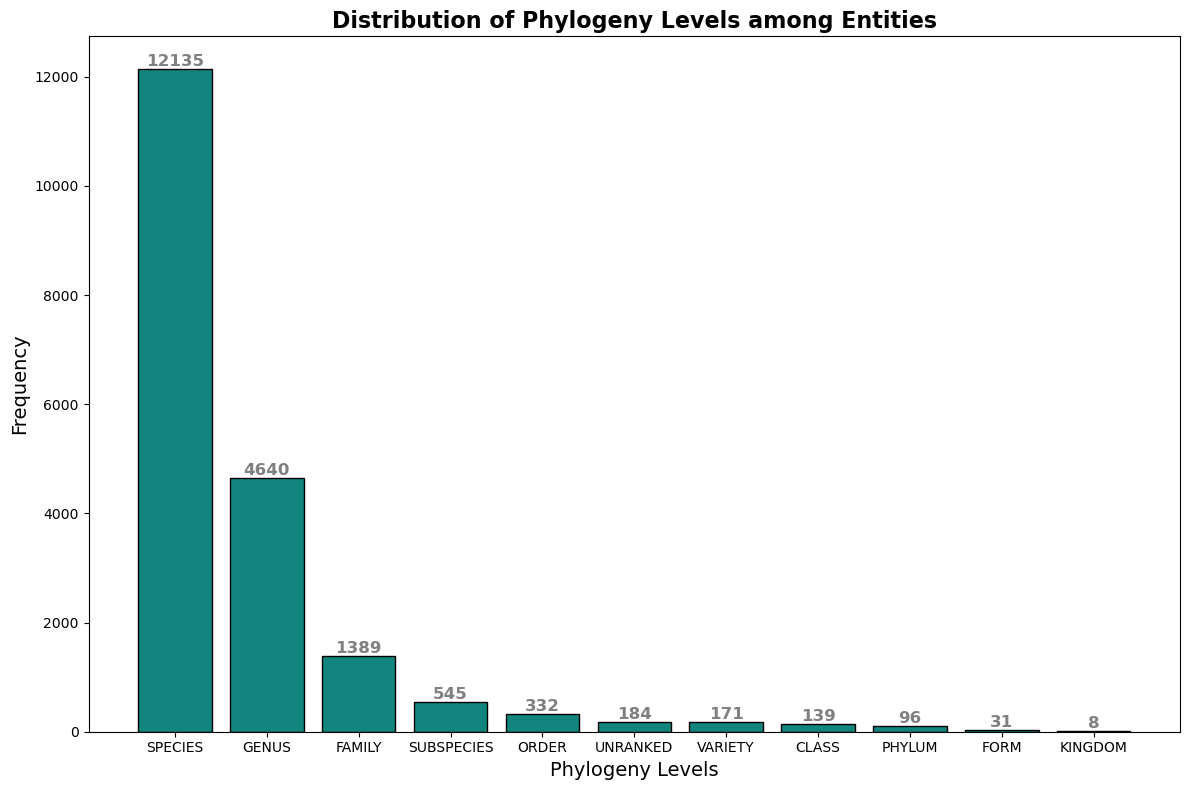

In [103]:
# Get the value counts of the 'rank' column
rank_counts = filtered_gbif_df['rank'].value_counts()

# Plotting the distribution of values from gbif_df['rank']
plt.figure(figsize=(12, 8))
plt.bar(rank_counts.index, rank_counts.values, color='#12867E', edgecolor='black')
plt.xlabel('Phylogeny Levels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Phylogeny Levels among Entities', fontsize=16, weight='bold')

# Adding totals at the top of the bars
for i, value in enumerate(rank_counts.values):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12, color='grey', weight='bold')

plt.tight_layout()


plt.savefig('C:/Users/maria/OneDrive/Documentos/Thesis/Report/NER_phylo_rank.png')

plt.show()

In [104]:
species_df = filtered_gbif_df[filtered_gbif_df['rank'] == 'SPECIES']
species_df

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
7,GBIF:1000410,Methanogenium frigidum,NaN,NaN,"Methanogenium frigidum Franzmann et al., 1997",Methanogenium frigidum,SPECIES,NaN,NaN,NaN,...,Methanogenium frigidum,2,10764301.0,162.0,566.0,7789.0,1000372.0,NaN,1000410.0,Methanomicrobia
9,GBIF:1000447,Hexarthra mira,NaN,NaN,"Hexarthra mira (Hudson, 1871)",Hexarthra mira,SPECIES,NaN,NaN,NaN,...,Hexarthra mira,1,91.0,307.0,1005.0,7519.0,1000426.0,NaN,1000447.0,Eurotatoria
12,GBIF:1001202,Habrotrocha angusticollis,NaN,NaN,"Habrotrocha angusticollis (Murray, 1905)",Habrotrocha angusticollis,SPECIES,NaN,NaN,NaN,...,Habrotrocha angusticollis,1,91.0,307.0,1234.0,8056.0,1001165.0,NaN,1001202.0,Eurotatoria
14,GBIF:1001917,Asplanchna girodi,NaN,NaN,"Asplanchna girodi de Guerne, 1888",Asplanchna girodi,SPECIES,NaN,NaN,NaN,...,Asplanchna girodi,1,91.0,307.0,1235.0,8059.0,1001916.0,NaN,1001917.0,Eurotatoria
18,GBIF:1002486,Lecane inermis,NaN,NaN,"Lecane inermis (Bryce, 1892)",Lecane inermis,SPECIES,NaN,NaN,NaN,...,Lecane inermis,1,91.0,307.0,1235.0,8064.0,1002167.0,NaN,1002486.0,Eurotatoria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21585,GBIF:9939451,Orius sauteri,NaN,NaN,Orius sauteri,Orius sauteri,SPECIES,NaN,NaN,NaN,...,Orius sauteri,1,54.0,216.0,809.0,7876.0,2020888.0,NaN,9939451.0,Insecta
21587,GBIF:9958093,Epeira spec,NaN,NaN,"Epeira spec Thorell, 1875",Epeira spec,SPECIES,NaN,NaN,NaN,...,Araneus spec,1,54.0,367.0,1496.0,7359.0,2159718.0,NaN,9878247.0,Arachnida
21589,GBIF:9977012,Phyllanthus emblica,NaN,NaN,Phyllanthus emblica,Phyllanthus emblica,SPECIES,NaN,NaN,NaN,...,Phyllanthus emblica,1,44.0,212.0,729.0,6101112.0,2493569.0,NaN,9977012.0,Aves
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,Spinturnix andegavinus,1,54.0,367.0,1109.0,4549059.0,4407627.0,NaN,9982023.0,Arachnida


In [112]:
duplicates_df = filtered_gbif_df[filtered_gbif_df.duplicated(subset='gbif_id', keep=False)]
duplicates_df.sort_values(by='gbif_id')
print(duplicates_df['gbif_id'].nunique())
duplicates_df

1948


,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
1,GBIF:1000,scorpionfly,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
2,GBIF:1000,Mecoptera,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
24,GBIF:1003,Trichoptera,NaN,NaN,Trichoptera,Trichoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1003.0,NaN,NaN,NaN,NaN,Insecta
25,GBIF:1003,caddisflies,NaN,NaN,Trichoptera,Trichoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1003.0,NaN,NaN,NaN,NaN,Insecta
26,GBIF:1003,caddisfly,NaN,NaN,Trichoptera,Trichoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1003.0,NaN,NaN,NaN,NaN,Insecta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21534,GBIF:9809229,Sturnus vulgaris,NaN,NaN,"Sturnus vulgaris Linnaeus, 1758",Sturnus vulgaris,SPECIES,NaN,NaN,NaN,...,Sturnus vulgaris,1,44.0,212.0,729.0,9350.0,2489099.0,NaN,9809229.0,Aves
21535,GBIF:9809229,European Starling,NaN,NaN,"Sturnus vulgaris Linnaeus, 1758",Sturnus vulgaris,SPECIES,NaN,NaN,NaN,...,Sturnus vulgaris,1,44.0,212.0,729.0,9350.0,2489099.0,NaN,9809229.0,Aves
21536,GBIF:9809229,starling,NaN,NaN,"Sturnus vulgaris Linnaeus, 1758",Sturnus vulgaris,SPECIES,NaN,NaN,NaN,...,Sturnus vulgaris,1,44.0,212.0,729.0,9350.0,2489099.0,NaN,9809229.0,Aves
21545,GBIF:9813242,Merlin,NaN,NaN,"Falco columbarius Linnaeus, 1758",Falco columbarius,SPECIES,NaN,NaN,NaN,...,Falco columbarius,1,44.0,212.0,7191407.0,5240.0,2480996.0,NaN,9813242.0,Aves


In [114]:
double_filtered_gbif_df = species_df.drop_duplicates(subset=['gbif_id'], keep='first')
double_filtered_gbif_df

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
7,GBIF:1000410,Methanogenium frigidum,NaN,NaN,"Methanogenium frigidum Franzmann et al., 1997",Methanogenium frigidum,SPECIES,NaN,NaN,NaN,...,Methanogenium frigidum,2,10764301.0,162.0,566.0,7789.0,1000372.0,NaN,1000410.0,Methanomicrobia
9,GBIF:1000447,Hexarthra mira,NaN,NaN,"Hexarthra mira (Hudson, 1871)",Hexarthra mira,SPECIES,NaN,NaN,NaN,...,Hexarthra mira,1,91.0,307.0,1005.0,7519.0,1000426.0,NaN,1000447.0,Eurotatoria
12,GBIF:1001202,Habrotrocha angusticollis,NaN,NaN,"Habrotrocha angusticollis (Murray, 1905)",Habrotrocha angusticollis,SPECIES,NaN,NaN,NaN,...,Habrotrocha angusticollis,1,91.0,307.0,1234.0,8056.0,1001165.0,NaN,1001202.0,Eurotatoria
14,GBIF:1001917,Asplanchna girodi,NaN,NaN,"Asplanchna girodi de Guerne, 1888",Asplanchna girodi,SPECIES,NaN,NaN,NaN,...,Asplanchna girodi,1,91.0,307.0,1235.0,8059.0,1001916.0,NaN,1001917.0,Eurotatoria
18,GBIF:1002486,Lecane inermis,NaN,NaN,"Lecane inermis (Bryce, 1892)",Lecane inermis,SPECIES,NaN,NaN,NaN,...,Lecane inermis,1,91.0,307.0,1235.0,8064.0,1002167.0,NaN,1002486.0,Eurotatoria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21585,GBIF:9939451,Orius sauteri,NaN,NaN,Orius sauteri,Orius sauteri,SPECIES,NaN,NaN,NaN,...,Orius sauteri,1,54.0,216.0,809.0,7876.0,2020888.0,NaN,9939451.0,Insecta
21587,GBIF:9958093,Epeira spec,NaN,NaN,"Epeira spec Thorell, 1875",Epeira spec,SPECIES,NaN,NaN,NaN,...,Araneus spec,1,54.0,367.0,1496.0,7359.0,2159718.0,NaN,9878247.0,Arachnida
21589,GBIF:9977012,Phyllanthus emblica,NaN,NaN,Phyllanthus emblica,Phyllanthus emblica,SPECIES,NaN,NaN,NaN,...,Phyllanthus emblica,1,44.0,212.0,729.0,6101112.0,2493569.0,NaN,9977012.0,Aves
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,Spinturnix andegavinus,1,54.0,367.0,1109.0,4549059.0,4407627.0,NaN,9982023.0,Arachnida


In [115]:
duplicates_name_df = filtered_gbif_df[filtered_gbif_df.duplicated(subset='name', keep=False)]
duplicates_name_df.sort_values(by='name')
duplicates_name_df

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
2,GBIF:1000,Mecoptera,NaN,NaN,Mecoptera,Mecoptera,ORDER,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1000.0,NaN,NaN,NaN,NaN,Insecta
10,GBIF:1000581,Rotifer,NaN,NaN,"Rotifer Cuvier, 1797",Rotifer,GENUS,NaN,NaN,NaN,...,NaN,1,91.0,307.0,1234.0,8058.0,1000581.0,NaN,NaN,Eurotatoria
17,GBIF:10022854,Schizophyllum,NaN,NaN,Schizophyllum (R.M.Schust.) Váňa & L.Söderstr.,Schizophyllum,GENUS,NaN,NaN,NaN,...,NaN,6,9.0,126.0,381.0,2292.0,8529264.0,NaN,NaN,Jungermanniopsida
19,GBIF:10026259,Mycobacterium tuberculosis,NaN,NaN,"Mycobacterium tuberculosis Zopf, 1883",Mycobacterium tuberculosis,SPECIES,NaN,NaN,NaN,...,Mycobacterium tuberculosis,3,10813635.0,10701801.0,10877327.0,8084.0,8018537.0,NaN,3225140.0,Actinomycetia
22,GBIF:10028909,Cerceris,NaN,NaN,Cerceris,Cerceris,GENUS,NaN,NaN,NaN,...,NaN,1,54.0,216.0,1457.0,7906.0,10028909.0,NaN,NaN,Insecta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21586,GBIF:9946976,? townsendii,NaN,NaN,"? townsendii Bachman, 1839",? townsendii,UNRANKED,NaN,NaN,NaN,...,NaN,1,44.0,359.0,1459.0,9437.0,NaN,NaN,NaN,Mammalia
21588,GBIF:9964259,? spec,NaN,NaN,"? spec Barsbold, 1974",? spec,UNRANKED,NaN,NaN,NaN,...,NaN,1,44.0,NaN,NaN,3238984.0,NaN,NaN,NaN,NaN
21589,GBIF:9977012,Phyllanthus emblica,NaN,NaN,Phyllanthus emblica,Phyllanthus emblica,SPECIES,NaN,NaN,NaN,...,Phyllanthus emblica,1,44.0,212.0,729.0,6101112.0,2493569.0,NaN,9977012.0,Aves
21590,GBIF:9979132,Pseudomyrma,NaN,NaN,Pseudomyrma,Pseudomyrma,GENUS,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,9979132.0,NaN,NaN,NaN


In [116]:
double_filtered_gbif_df = double_filtered_gbif_df.drop_duplicates(subset=['name'], keep='first')
double_filtered_gbif_df

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
7,GBIF:1000410,Methanogenium frigidum,NaN,NaN,"Methanogenium frigidum Franzmann et al., 1997",Methanogenium frigidum,SPECIES,NaN,NaN,NaN,...,Methanogenium frigidum,2,10764301.0,162.0,566.0,7789.0,1000372.0,NaN,1000410.0,Methanomicrobia
9,GBIF:1000447,Hexarthra mira,NaN,NaN,"Hexarthra mira (Hudson, 1871)",Hexarthra mira,SPECIES,NaN,NaN,NaN,...,Hexarthra mira,1,91.0,307.0,1005.0,7519.0,1000426.0,NaN,1000447.0,Eurotatoria
12,GBIF:1001202,Habrotrocha angusticollis,NaN,NaN,"Habrotrocha angusticollis (Murray, 1905)",Habrotrocha angusticollis,SPECIES,NaN,NaN,NaN,...,Habrotrocha angusticollis,1,91.0,307.0,1234.0,8056.0,1001165.0,NaN,1001202.0,Eurotatoria
14,GBIF:1001917,Asplanchna girodi,NaN,NaN,"Asplanchna girodi de Guerne, 1888",Asplanchna girodi,SPECIES,NaN,NaN,NaN,...,Asplanchna girodi,1,91.0,307.0,1235.0,8059.0,1001916.0,NaN,1001917.0,Eurotatoria
18,GBIF:1002486,Lecane inermis,NaN,NaN,"Lecane inermis (Bryce, 1892)",Lecane inermis,SPECIES,NaN,NaN,NaN,...,Lecane inermis,1,91.0,307.0,1235.0,8064.0,1002167.0,NaN,1002486.0,Eurotatoria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21582,GBIF:9923638,Laspeyresia pomonella,NaN,NaN,"Laspeyresia pomonella (Linnaeus, 1758)",Laspeyresia pomonella,SPECIES,NaN,NaN,NaN,...,Cydia pomonella,1,54.0,216.0,797.0,5343.0,1737701.0,NaN,1737847.0,Insecta
21585,GBIF:9939451,Orius sauteri,NaN,NaN,Orius sauteri,Orius sauteri,SPECIES,NaN,NaN,NaN,...,Orius sauteri,1,54.0,216.0,809.0,7876.0,2020888.0,NaN,9939451.0,Insecta
21587,GBIF:9958093,Epeira spec,NaN,NaN,"Epeira spec Thorell, 1875",Epeira spec,SPECIES,NaN,NaN,NaN,...,Araneus spec,1,54.0,367.0,1496.0,7359.0,2159718.0,NaN,9878247.0,Arachnida
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,Spinturnix andegavinus,1,54.0,367.0,1109.0,4549059.0,4407627.0,NaN,9982023.0,Arachnida


In [107]:
duplicate_species_df = duplicates_df[duplicates_df['rank'] == 'SPECIES']
duplicate_species_df

,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
35,GBIF:1003642,Lophopus crystallinus,NaN,NaN,"Lophopus crystallinus (Pallas, 1768)",Lophopus crystallinus,SPECIES,NaN,NaN,NaN,...,Lophopus crystallinus,1,53.0,139.0,1070.0,3508.0,1003640.0,NaN,1003642.0,Phylactolaemata
36,GBIF:1003642,bellflower,NaN,NaN,"Lophopus crystallinus (Pallas, 1768)",Lophopus crystallinus,SPECIES,NaN,NaN,NaN,...,Lophopus crystallinus,1,53.0,139.0,1070.0,3508.0,1003640.0,NaN,1003642.0,Phylactolaemata
38,GBIF:1003652,"Cristatella mucedo Cuvier, 1798",NaN,NaN,"Cristatella mucedo Cuvier, 1798",Cristatella mucedo,SPECIES,NaN,NaN,NaN,...,Cristatella mucedo,1,53.0,139.0,1070.0,6907.0,1003651.0,NaN,1003652.0,Phylactolaemata
39,GBIF:1003652,Cristatella mucedo,NaN,NaN,"Cristatella mucedo Cuvier, 1798",Cristatella mucedo,SPECIES,NaN,NaN,NaN,...,Cristatella mucedo,1,53.0,139.0,1070.0,6907.0,1003651.0,NaN,1003652.0,Phylactolaemata
197,GBIF:1043097,"Adalia bipunctata (Linnaeus, 1758)",NaN,NaN,"Adalia bipunctata (Linnaeus, 1758)",Adalia bipunctata,SPECIES,NaN,NaN,NaN,...,Adalia bipunctata,1,54.0,216.0,1470.0,7782.0,1043096.0,NaN,1043097.0,Insecta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21534,GBIF:9809229,Sturnus vulgaris,NaN,NaN,"Sturnus vulgaris Linnaeus, 1758",Sturnus vulgaris,SPECIES,NaN,NaN,NaN,...,Sturnus vulgaris,1,44.0,212.0,729.0,9350.0,2489099.0,NaN,9809229.0,Aves
21535,GBIF:9809229,European Starling,NaN,NaN,"Sturnus vulgaris Linnaeus, 1758",Sturnus vulgaris,SPECIES,NaN,NaN,NaN,...,Sturnus vulgaris,1,44.0,212.0,729.0,9350.0,2489099.0,NaN,9809229.0,Aves
21536,GBIF:9809229,starling,NaN,NaN,"Sturnus vulgaris Linnaeus, 1758",Sturnus vulgaris,SPECIES,NaN,NaN,NaN,...,Sturnus vulgaris,1,44.0,212.0,729.0,9350.0,2489099.0,NaN,9809229.0,Aves
21545,GBIF:9813242,Merlin,NaN,NaN,"Falco columbarius Linnaeus, 1758",Falco columbarius,SPECIES,NaN,NaN,NaN,...,Falco columbarius,1,44.0,212.0,7191407.0,5240.0,2480996.0,NaN,9813242.0,Aves


In [108]:
# Remove the duplicates from species_df
species_df_cleaned = species_df[~species_df['gbif_id'].isin(duplicate_species_df['gbif_id'])]

# Verify the cleaned species dataframe
species_df_cleaned


,gbif_id,name,usageKey,acceptedUsageKey,scientificName,canonicalName,rank,status,confidence,note,...,species,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,class
7,GBIF:1000410,Methanogenium frigidum,NaN,NaN,"Methanogenium frigidum Franzmann et al., 1997",Methanogenium frigidum,SPECIES,NaN,NaN,NaN,...,Methanogenium frigidum,2,10764301.0,162.0,566.0,7789.0,1000372.0,NaN,1000410.0,Methanomicrobia
9,GBIF:1000447,Hexarthra mira,NaN,NaN,"Hexarthra mira (Hudson, 1871)",Hexarthra mira,SPECIES,NaN,NaN,NaN,...,Hexarthra mira,1,91.0,307.0,1005.0,7519.0,1000426.0,NaN,1000447.0,Eurotatoria
12,GBIF:1001202,Habrotrocha angusticollis,NaN,NaN,"Habrotrocha angusticollis (Murray, 1905)",Habrotrocha angusticollis,SPECIES,NaN,NaN,NaN,...,Habrotrocha angusticollis,1,91.0,307.0,1234.0,8056.0,1001165.0,NaN,1001202.0,Eurotatoria
14,GBIF:1001917,Asplanchna girodi,NaN,NaN,"Asplanchna girodi de Guerne, 1888",Asplanchna girodi,SPECIES,NaN,NaN,NaN,...,Asplanchna girodi,1,91.0,307.0,1235.0,8059.0,1001916.0,NaN,1001917.0,Eurotatoria
18,GBIF:1002486,Lecane inermis,NaN,NaN,"Lecane inermis (Bryce, 1892)",Lecane inermis,SPECIES,NaN,NaN,NaN,...,Lecane inermis,1,91.0,307.0,1235.0,8064.0,1002167.0,NaN,1002486.0,Eurotatoria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21585,GBIF:9939451,Orius sauteri,NaN,NaN,Orius sauteri,Orius sauteri,SPECIES,NaN,NaN,NaN,...,Orius sauteri,1,54.0,216.0,809.0,7876.0,2020888.0,NaN,9939451.0,Insecta
21587,GBIF:9958093,Epeira spec,NaN,NaN,"Epeira spec Thorell, 1875",Epeira spec,SPECIES,NaN,NaN,NaN,...,Araneus spec,1,54.0,367.0,1496.0,7359.0,2159718.0,NaN,9878247.0,Arachnida
21589,GBIF:9977012,Phyllanthus emblica,NaN,NaN,Phyllanthus emblica,Phyllanthus emblica,SPECIES,NaN,NaN,NaN,...,Phyllanthus emblica,1,44.0,212.0,729.0,6101112.0,2493569.0,NaN,9977012.0,Aves
21593,GBIF:9982023,Spinturnix andegavinus,NaN,NaN,"Spinturnix andegavinus Deunff, 1977",Spinturnix andegavinus,SPECIES,NaN,NaN,NaN,...,Spinturnix andegavinus,1,54.0,367.0,1109.0,4549059.0,4407627.0,NaN,9982023.0,Arachnida


In [110]:
len(gbif_entities_list)

21597